In [34]:
import os
import cv2
import json
import glob
import random
import numpy as np
from collections import Counter
import os.path as osp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
def crop_from_orig_anno(jersey_anno_dir, imgs_dir, output_dir, offset = 3):
    all_anno = []
    
    ### go through each game
    for anno_dir in tqdm(jersey_anno_dir): 
        
        dir_path = osp.join(output_dir, anno_dir.split('/')[-1])
        if not osp.exists(dir_path):
            os.makedirs(dir_path)
        

        ### go through each json data
        js_dir  = sorted(glob.glob(anno_dir + '/*.json'))
        for jersey_js in js_dir:

            ### Load new jersey data
            with open(jersey_js) as f:
                jersey_data = json.load(f)
                
            frame_num = osp.basename(jersey_js).replace('.json', '')

            ### Load image data
            
            img_path = os.path.join(imgs_dir, os.path.basename(anno_dir), os.path.basename(jersey_js).replace('.json', '.jpg'))
            if not os.path.exists(img_path):
                img_path = os.path.join(imgs_dir, os.path.basename(anno_dir), 'frame_' + os.path.basename(jersey_js).replace('.json', '.jpg'))
            
            
            img = cv2.imread(img_path)

            for shape in jersey_data['shapes']:

                label = shape['label']
                if 'j' in label:
                    label_split = label.split('_')
                    if len(label_split)==3:
                        track_id = label_split[1]
                        jersey_num = label_split[2]
                    elif len(label_split)==4:
                        track_id = label_split[1] + '_' + label_split[2]
                        jersey_num = label_split[-1]
                    
                    bbox_ = np.array([[int(x) for x in y] for y in shape['points']])
                    bbox_ = bbox_.flatten()

                    bbox_img = img[bbox_[1] - offset: bbox_[3] + offset, 
                                   bbox_[0] - offset: bbox_[2] + offset, :]
                    h,w,c = bbox_img.shape
                    
                    
                    output_path = osp.join(dir_path, '_'.join([str(frame_num), track_id, jersey_num]) + '.jpg')
                    
                    if h!=0 and w!=0:
                        cv2.imwrite(output_path, bbox_img)
                        all_anno.append((output_path, jersey_num))
                        
    return all_anno

### First task

In [3]:
imgs_dir = '/home/ubuntu/oljike/data/playerTrackingFrames/'
jersey_anno_dir = glob.glob('/home/ubuntu/oljike/PlayerTracking/data/second_task/*')
output_dir = '/home/ubuntu/oljike/ocr_jersey/JerseyClassifier/data/jersey_crops/'

In [4]:
all_anno = crop_from_orig_anno(jersey_anno_dir, imgs_dir, output_dir, 2)
print("Number of samples is ", len(all_anno))


Number of samples is  21513


### Second task

In [7]:
imgs_dir = '/home/ubuntu/oljike/data/playerTrackingFrames2/'
jersey_anno_dir = glob.glob('/home/ubuntu/oljike/PlayerTracking/data/third_task/*')
output_dir = '/home/ubuntu/oljike/ocr_jersey/JerseyClassifier/data/jersey_crops/'

In [8]:
all_anno.extend(crop_from_orig_anno(jersey_anno_dir, imgs_dir, output_dir, 2))
print("Number of samples is ", len(all_anno))


Number of samples is  44964


In [72]:
ALLOWED = [list(range(0,6)), list(range(10, 16)),
     list(range(20, 26)),list(range(30, 36)),
     list(range(40, 46)),list(range(50, 56)),]

ALLOWED = list(np.array(ALLOWED).flatten())
ALLOWED = [str(x) for x in ALLOWED]
ALLOWED.append('00')
ALLOWED = set(ALLOWED)



uniq_jersey = set()
cnt_jersey = []
not_all = []
for img_path, j in all_anno:
    uniq_jersey.add(j)
    cnt_jersey.append(j)
    if str(j) not in ALLOWED:
        img = cv2.imread(img_path)
        not_all.append((j, img))
    

print('Number of unique jersey labels is ', len(uniq_jersey))
print('the number of not allowed jersey numbers is ', len(not_all))
print('the counter of jersey number is ', Counter(cnt_jersey))

Number of unique jersey labels is  37
the number of not allowed jersey numbers is  38
the counter of jersey number is  Counter({'5': 5310, '2': 4462, '3': 4164, '1': 3990, '0': 2685, '4': 2648, '10': 2603, '11': 2362, '13': 1759, '33': 1344, '24': 1324, '12': 1276, '21': 1270, '15': 1238, '14': 1185, '25': 1155, '20': 876, '55': 868, '23': 864, '30': 700, '34': 680, '35': 561, '22': 435, '32': 369, '00': 280, '41': 150, '31': 131, '45': 94, '42': 55, '51': 46, '53': 42, '19': 28, '7': 3, '27': 2, '17': 2, '8': 2, '6': 1})


4
Label  19


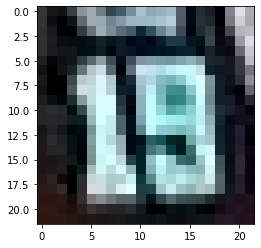

In [70]:
idx = random.choice(range(len(not_all)))
print(idx)
img = not_all[idx][1]
print('Label ', not_all[idx][0])
plt.imshow(img)

### Create the label files

In [9]:
val_dirs = ['2020.01.04-Duke_at_MiamiFL', '2019-01-12_Tennessee_at_Florida', '2020.02.03-NorthCarolina_at_FloridaState', 
           '2018.11.27-Indiana_at_Duke', '2019-02-11_Virginia_at_North_Carolina', '2019.01.22-Duke_at_Pittsburgh', 
           '2019.02.26-Duke_at_VirginiaTech', '2019.03.14-ACC-Syracuse_at_Duke', 
           '2020.02.13-Colorado_at_Oregon', '2020.02.22-Michigan_at_Purdue', 
            '2020.02.25-NorthCarolinaState_at_NorthCarolina',
           '2021_01_20_Colorado_at_Washington', '2021_01_23_UCLA_at_Stanford',
            '2021_01_31_UNLV_at_Nevada', '2021_01_23_VirginiaMilitary_at_Mercer',
            '2021_01_14_Washington_at_USC', '2021_01_24_Utah_at_Washington']

f_train = open('./data/jersey_crops_train.txt', 'w')
f_val = open('./data/jersey_crops_val.txt', 'w')

for anno in tqdm(all_anno):
    dir_name = anno[0].split('/')[-2]
    
    if dir_name in val_dirs:
        f_val.writelines(','.join([anno[0], anno[1]]) + '\n')
    else:
        f_train.writelines(','.join([anno[0], anno[1]]) + '\n')
        
f_train.close()
f_val.close()

In [10]:
with open('./data/jersey_crops_train.txt') as f:
    train_data = f.readlines()
    
with open('./data/jersey_crops_val.txt') as f:
    val_data = f.readlines()
    
print("Number of train samples is {} and val samples is {}".format(len(train_data), len(val_data)))  

Number of train samples is 36160 and val samples is 8804


Label  3



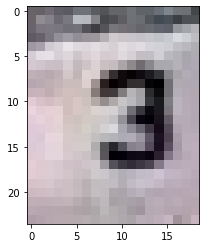

In [30]:
idx = random.choice(range(len(train_data)))
img = cv2.imread(train_data[idx].split(',')[0])
print('Label ', train_data[idx].split(',')[1])
plt.imshow(img)

### Create detector crops

In [31]:
val_dirs = ['2020.01.04-Duke_at_MiamiFL', '2019-01-12_Tennessee_at_Florida', '2020.02.03-NorthCarolina_at_FloridaState', 
           '2018.11.27-Indiana_at_Duke', '2019-02-11_Virginia_at_North_Carolina', '2019.01.22-Duke_at_Pittsburgh', 
           '2019.02.26-Duke_at_VirginiaTech', '2019.03.14-ACC-Syracuse_at_Duke', 
           '2020.02.13-Colorado_at_Oregon', '2020.02.22-Michigan_at_Purdue', 
            '2020.02.25-NorthCarolinaState_at_NorthCarolina', 
            '2021_01_20_Colorado_at_Washington', '2021_01_23_UCLA_at_Stanford',
            '2021_01_31_UNLV_at_Nevada', '2021_01_23_VirginiaMilitary_at_Mercer',
            '2021_01_14_Washington_at_USC', '2021_01_24_Utah_at_Washington']


cnt = 0
f_val = open('./data/detector_val_path.txt', 'w')
all_crops = glob.glob('/home/ubuntu/oljike/ocr_jersey/yolo_jersey_region/data/player_crops/*')
for crop_dir in tqdm(all_crops):
    dir_name = crop_dir.split('/')[-1]

    
    if dir_name in val_dirs:
        curr_dir_imgs = glob.glob(crop_dir + '/*.jpg')
        for img_crop in curr_dir_imgs:
            cnt += 1
            f_val.writelines(img_crop + '\n')
f_val.close()

print("Number of crops is ", cnt)


Number of crops is  8507


### Upload to S3


In [1]:
!zip -r data/jersey_crops.zip data/jersey_crops

  adding: data/jersey_crops/ (stored 0%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/ (stored 0%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3284_1_20.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3092_5_13.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2777_2_3.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2867_8_13.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3008_8_13.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3131_8_3.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2723_9_22.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3149_3_5.jpg (deflated 25%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2996_6_5.jpg (deflated 16%)
  adding: data/

  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2915_6_55.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3278_2_3.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2933_1_20.jpg (deflated 10%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2762_6_55.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2897_10_2.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2852_3_5.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3143_10_2.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2786_2_3.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3065_3_5.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2708_5_13.jpg (deflated 14%)
  adding: data/jersey_crops/2021_0

  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3218_7_10.jpg (deflated 10%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2756_2_3.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3122_4_14.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3020_5_13.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2852_10_21.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3101_4_14.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3281_6_55.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2828_3_5.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3071_5_13.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3113_1_20.jpg (deflated 13%)
  adding: data/jersey_crops/202

  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3044_4_14.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3074_3_5.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2750_7_10.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2996_7_10.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2891_4_14.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2855_10_21.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2924_6_5.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3155_5_13.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3209_2_3.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3053_6_5.jpg (deflated 19%)
  adding: data/jersey_crops/2021_

  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3113_9_22.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2750_8_1.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2798_10_2.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2723_8_1.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2837_1_20.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3251_1_20.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2888_5_13.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3029_3_5.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2876_10_21.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2723_5_13.jpg (deflated 15%)
  adding: data/jersey_crops/2021

  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2825_5_13.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2939_3_5.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2852_4_14.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2936_8_3.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2807_4_14.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2720_5_13.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2750_5_13.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2873_4_14.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3110_6_5.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3020_1_2.jpg (deflated 18%)
  adding: data/jersey_crops/2021_0

  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2741_3_5.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2849_8_13.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2840_2_3.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2738_10_21.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2864_1_20.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2969_3_5.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3098_6_5.jpg (deflated 26%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2942_1_20.jpg (deflated 10%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2702_10_2.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3080_3_5.jpg (deflated 21%)
  adding: data/jersey_crops/2021_0

  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2717_7_10.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2726_3_5.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3050_9_22.jpg (deflated 8%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3281_3_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3107_2_3.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3263_2_3.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2741_8_1.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2843_4_14.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2972_7_10.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3047_9_22.jpg (deflated 8%)
  adding: data/jersey_crops/2021_01_0

  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2801_9_2.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3095_9_22.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2756_3_5.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2786_10_21.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2792_3_5.jpg (deflated 25%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3071_8_13.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3242_3_5.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3158_8_13.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3065_5_13.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2861_7_0.jpg (deflated 20%)
  adding: data/jersey_crops/2021_0

  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3017_4_14.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3122_2_3.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_3287_2_3.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_07_Washington_at_Stanford/frame_2816_9_2.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/ (stored 0%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140797_1_15.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140740_4_0.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140779_5_5.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141217_8_10.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140716_2_30.jpg (deflated 11%)
  adding: data/jersey_c

  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140776_4_0.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141241_5_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140659_7_20.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141211_8_10.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140800_7_20.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140725_1_15.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141175_7_20.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140710_4_0.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140731_1_15.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_1412

  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141223_6_2.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140806_7_20.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140767_2_30.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140689_3_34.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140734_4_0.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141232_10_3.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140761_3_34.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140761_1_15.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140653_6_22.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140

  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141232_7_20.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140779_7_20.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140743_4_0.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140698_1_15.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140809_5_5.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140758_1_15.jpg (deflated 10%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141241_10_3.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140806_4_0.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140833_10_1.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_1411

  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141229_11_2.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140785_8_10.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141205_2_30.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140788_7_20.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141175_10_3.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141241_3_34.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140716_3_34.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140764_10_3.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140677_3_34.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_1

  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141163_10_3.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140833_6_22.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140755_2_30.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141244_5_5.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140782_2_30.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140707_7_21.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140725_6_2.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141184_2_30.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140653_3_34.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140

  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141226_7_20.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141208_10_3.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141160_6_22.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141202_11_2.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141181_10_3.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140767_4_0.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140776_5_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140743_5_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141160_4_0.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_14082

  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140794_1_15.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140791_2_30.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141238_10_3.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140806_2_30.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141163_7_20.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141202_7_20.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140791_3_34.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_141214_6_22.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_140722_6_22.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_23_VirginiaMilitary_at_Mercer/frame_1

  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2322_6_34.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2679_3_11.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2280_3_11.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2172_8_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2166_10_10.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2664_10_10.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2220_8_5.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2622_3_11.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2184_2_13.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2283_5_5.

  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2289_2_13.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2196_8_5.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2301_2_13.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2322_1_1.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2667_10_10.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2244_8_5.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2376_6_34.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2277_7_2.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2625_3_11.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2283_1_1.jpg

  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2325_2_13.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2301_3_11.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2700_4_33.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2628_10_10.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2700_2_13.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2283_7_2.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2175_8_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2676_3_11.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2685_9_30.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2670_2_13.

  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2217_7_2.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2298_3_11.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2220_10_10.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2187_8_5.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2223_3_11.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2280_7_2.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2616_4_33.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2292_3_11.jpg (deflated 25%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2283_2_13.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2241_7_2.jp

  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2622_9_30.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2664_5_5.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2598_9_30.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2361_2_13.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2229_1_1.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2628_9_30.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2637_10_10.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2241_3_11.jpg (deflated 26%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2661_10_10.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_16_Citadel_at_VirginiaMilitary/frame_2631_5_5.

  adding: data/jersey_crops/2020.02.13-Colorado_at_Oregon/010695_8_5.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.13-Colorado_at_Oregon/010735_3_3.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.13-Colorado_at_Oregon/010965_1_5.jpg (deflated 24%)
  adding: data/jersey_crops/2020.02.13-Colorado_at_Oregon/011445_1_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.13-Colorado_at_Oregon/010935_7_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.13-Colorado_at_Oregon/011095_8_5.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.13-Colorado_at_Oregon/011305_10_25.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.13-Colorado_at_Oregon/011175_7_0.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.13-Colorado_at_Oregon/011105_7_0.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.13-Colorado_at_Oregon/010605_5_21.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.13-Colorado_at_Oregon/010695_10_25.jpg (deflated 22%)
  adding: data/jersey_crops

  adding: data/jersey_crops/2020.02.13-Colorado_at_Oregon/011135_8_5.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.13-Colorado_at_Oregon/010815_5_21.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.13-Colorado_at_Oregon/010635_10_25.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.13-Colorado_at_Oregon/010745_4_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.13-Colorado_at_Oregon/010855_5_21.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/ (stored 0%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_616_9_20.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_916_8_3.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_721_3_4.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_958_2_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_748_8_3.

  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_709_2_5.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_955_2_5.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_748_4_34.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_898_8_3.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_835_1_10.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_844_2_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_817_7_2.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_640_2_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_760_8_3.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_991_2_5.jpg (deflated 19%)
  adding

  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_880_2_5.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_868_1_10.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_532_5_10.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_808_9_20.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_976_8_3.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_760_3_4.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_760_9_20.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_925_5_10.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_868_8_3.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_20_Furman_at_VirginiaMilitary/frame_973_2_5.jpg (deflated 20%)
  add

  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_436_7_1.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_709_5_3.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_472_7_1.jpg (deflated 25%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_442_10_21.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_646_2_35.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_310_6_24.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_259_1_5.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_451_9_2.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_589_8_11.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_62

  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_583_8_11.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_568_8_11.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_559_8_11.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_493_6_24.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_382_5_3.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_328_6_24.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_160_10_21.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_478_7_1.jpg (deflated 26%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_565_3_24.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame

  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_340_6_24.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_427_6_24.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_631_6_24.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_166_8_11.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_586_10_21.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_616_10_21.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_166_3_24.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_346_7_1.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_421_4_55.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/fra

  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_538_5_3.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_610_3_24.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_619_6_24.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_421_9_2.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_511_8_11.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_223_4_55.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_319_6_24.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_442_6_24.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_538_4_55.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_

  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_283_6_24.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_187_9_2.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_472_8_11.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_730_3_24.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_424_4_55.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_649_2_35.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_676_4_55.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_592_6_24.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_406_4_55.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame

  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_349_4_55.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_550_4_55.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_499_3_24.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_712_5_3.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_523_5_3.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_583_4_55.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_568_4_55.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_466_6_24.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_469_8_11.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_

  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_370_4_55.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_553_4_55.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_487_4_55.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_607_6_24.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_517_4_55.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_220_3_24.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_406_5_3.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_628_10_21.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/frame_544_6_24.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_16_ClevelandState_at_WrightState/fram

  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2583_6_2.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2568_6_2.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2565_10_4.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2454_6_2.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2586_6_2.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2475_6_2.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2445_6_2.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2550_5_13.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2496_6_2.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2697_5_13.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_24

  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2220_5_13.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2475_10_4.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2586_2_23.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2649_5_13.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2616_5_13.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2808_10_4.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2238_5_13.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2775_4_21.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2472_6_2.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2604_10_4.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/fr

  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2268_4_21.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2709_10_4.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2715_1_0.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2673_1_0.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2739_5_13.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2760_4_21.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2538_6_2.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2310_10_4.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2565_2_23.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/frame_2535_2_23.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_09_USC_at_ArizonaState/fram

  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002371_3_0.jpg (deflated 16%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/003211_5_2.jpg (deflated 20%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002326_9_3.jpg (deflated 20%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002316_6_10.jpg (deflated 15%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002276_9_3.jpg (deflated 19%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/003181_6_10.jpg (deflated 19%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002661_8_13.jpg (deflated 21%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002296_8_13.jpg (deflated 19%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002471_8_13.jpg (deflated 22%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/003241_5_2.jpg (deflated 19%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002666_5_2.jpg (deflated 22%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/00267

  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/003181_5_2.jpg (deflated 20%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002401_1_1.jpg (deflated 17%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002901_10_3.jpg (deflated 20%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002301_9_3.jpg (deflated 21%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/003131_5_2.jpg (deflated 17%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002396_9_3.jpg (deflated 22%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002631_8_13.jpg (deflated 25%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002496_1_1.jpg (deflated 20%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002691_7_20.jpg (deflated 25%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/003221_6_10.jpg (deflated 19%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/003251_5_2.jpg (deflated 18%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002906

  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002271_7_20.jpg (deflated 18%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002716_10_3.jpg (deflated 18%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002281_10_3.jpg (deflated 19%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002566_3_0.jpg (deflated 19%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002366_6_10.jpg (deflated 17%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002616_3_0.jpg (deflated 21%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002751_10_3.jpg (deflated 17%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002566_8_13.jpg (deflated 24%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/003056_7_20.jpg (deflated 21%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002661_4_1.jpg (deflated 21%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002621_4_1.jpg (deflated 23%)
  adding: data/jersey_crops/2018.11.27-Indiana_at_Duke/002

  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005304_9_13.jpg (deflated 20%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004609_5_5.jpg (deflated 22%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005144_5_5.jpg (deflated 19%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004479_2_15.jpg (deflated 22%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004784_10_11.jpg (deflated 19%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004814_2_15.jpg (deflated 21%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005219_10_11.jpg (deflated 17%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005449_7_33.jpg (deflated 14%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004854_5_5.jpg (deflated 20%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004714_1_32.jpg (deflated 19%)
  adding: data/jersey_crops/201

  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005159_7_33.jpg (deflated 13%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005294_9_13.jpg (deflated 22%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004724_1_32.jpg (deflated 19%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004969_10_11.jpg (deflated 18%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004989_7_33.jpg (deflated 13%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004854_10_11.jpg (deflated 19%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005364_7_33.jpg (deflated 15%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005204_7_33.jpg (deflated 13%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005299_9_13.jpg (deflated 18%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004994_10_11.jpg (deflated 18%)
  adding: data/jersey_crops

  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005149_2_15.jpg (deflated 23%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004734_6_24.jpg (deflated 23%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005414_5_5.jpg (deflated 23%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005264_9_13.jpg (deflated 18%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004869_8_0.jpg (deflated 24%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005014_7_33.jpg (deflated 14%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005354_10_11.jpg (deflated 15%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004854_7_33.jpg (deflated 14%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004729_1_32.jpg (deflated 18%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005139_9_13.jpg (deflated 18%)
  adding: data/jersey_crops/201

  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004709_1_32.jpg (deflated 18%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004894_10_11.jpg (deflated 19%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005164_9_13.jpg (deflated 16%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005164_10_11.jpg (deflated 18%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004869_7_33.jpg (deflated 15%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004759_10_11.jpg (deflated 19%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005399_1_32.jpg (deflated 15%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004619_7_33.jpg (deflated 20%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005204_6_24.jpg (deflated 21%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004654_7_33.jpg (deflated 17%)
  adding: data/jersey_crops

  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005069_6_24.jpg (deflated 20%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005294_7_33.jpg (deflated 15%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005169_10_11.jpg (deflated 15%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005099_9_13.jpg (deflated 18%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005069_7_33.jpg (deflated 14%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005244_9_13.jpg (deflated 18%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005139_3_12.jpg (deflated 21%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004639_6_24.jpg (deflated 20%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004894_8_0.jpg (deflated 21%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004739_6_24.jpg (deflated 24%)
  adding: data/jersey_crops/20

  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005194_2_15.jpg (deflated 20%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005454_9_13.jpg (deflated 17%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005149_7_33.jpg (deflated 16%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005129_9_13.jpg (deflated 17%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/004874_8_0.jpg (deflated 26%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005069_3_12.jpg (deflated 23%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005034_5_5.jpg (deflated 21%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005434_1_32.jpg (deflated 18%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005379_7_33.jpg (deflated 14%)
  adding: data/jersey_crops/2019-02-11_Virginia_at_North_Carolina/005349_10_11.jpg (deflated 14%)
  adding: data/jersey_crops/201

  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005369_3_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005229_1_55.jpg (deflated 12%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005024_3_2.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005384_3_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005044_6_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005334_3_2.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005289_3_2.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005184_10_3.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005284_10_3.jpg (deflated 24%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005534_2_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005099_3_2.jpg (deflated 16%)
  adding: data/jersey_crops/2

  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005319_10_3.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005524_6_2.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005504_2_3.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/004984_1_55.jpg (deflated 12%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005834_2_3.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005329_3_2.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005224_8_12.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005124_10_3.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005644_9_19.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/004989_9_19.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005889_4_21.jpg (deflated 22%)
  adding: data/jersey_cro

  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005364_2_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005304_1_55.jpg (deflated 12%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005029_1_55.jpg (deflated 11%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005539_2_3.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005434_5_32.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/004999_6_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/004959_3_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005044_1_55.jpg (deflated 10%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005444_7_55.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005544_5_32.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005749_9_15.jpg (deflated 17%)
  adding: data/jersey_cro

  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005349_2_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005114_3_2.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005324_2_3.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/004989_3_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005609_3_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005034_6_2.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005579_8_12.jpg (deflated 13%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005019_8_12.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005864_2_3.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005384_10_3.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005764_7_55.jpg (deflated 20%)
  adding: data/jersey_crops/

  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005029_10_3.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005484_2_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005019_10_3.jpg (deflated 24%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005794_5_32.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005274_10_3.jpg (deflated 25%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005809_9_15.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005684_9_15.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005244_10_3.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/004969_1_55.jpg (deflated 12%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/005009_5_32.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.22-Michigan_at_Purdue/004994_3_2.jpg (deflated 16%)
  adding: data/jersey_c

  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/003032_9_5.jpg (deflated 22%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/002527_5_5.jpg (deflated 22%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/002437_4_41.jpg (deflated 14%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/002947_1_2.jpg (deflated 20%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/002582_3_3.jpg (deflated 19%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/003047_9_5.jpg (deflated 19%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/002482_4_41.jpg (deflated 18%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/003342_1_2.jpg (deflated 23%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/003122_4_41.jpg (deflated 19%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/003327_10_1.jpg (deflated 21%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/002887_9_5.jpg (deflated 23%)
  adding: data/jersey_crops/

  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/002387_2_2.jpg (deflated 19%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/002972_7_1.jpg (deflated 26%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/003107_4_41.jpg (deflated 18%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/003207_8_21.jpg (deflated 19%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/002497_4_41.jpg (deflated 17%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/002942_9_5.jpg (deflated 22%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/003312_8_21.jpg (deflated 26%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/002772_9_5.jpg (deflated 20%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/002417_3_3.jpg (deflated 18%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/002512_8_21.jpg (deflated 23%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/003182_2_2.jpg (deflated 19%)
  adding: data/jersey_crops

  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/003367_5_5.jpg (deflated 23%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/003042_9_5.jpg (deflated 22%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/003082_2_2.jpg (deflated 17%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/003062_9_5.jpg (deflated 20%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/002392_3_3.jpg (deflated 18%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/002752_9_5.jpg (deflated 24%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/002567_4_41.jpg (deflated 17%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/002842_2_2.jpg (deflated 17%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/003017_9_5.jpg (deflated 21%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/002397_1_2.jpg (deflated 18%)
  adding: data/jersey_crops/2019.01.22-Duke_at_Pittsburgh/002707_9_5.jpg (deflated 22%)
  adding: data/jersey_crops/201

  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_953_3_3.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_923_2_24.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_773_2_24.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_839_3_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_926_1_55.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_785_7_15.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_1058_2_24.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_1064_2_24.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_746_4_35.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_1

  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_1097_7_15.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_677_1_55.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_800_3_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_866_2_24.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_659_3_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_854_2_24.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_692_1_55.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_515_5_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_1022_3_3.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_19_

  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_560_2_2.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_884_3_3.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_1007_10_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_995_9_0.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_1064_3_3.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_1034_2_24.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_854_3_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_1016_4_35.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_1043_1_55.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_1

  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_1058_7_15.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_779_2_24.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_500_6_1.jpg (deflated 24%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_887_1_55.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_986_8_5.jpg (deflated 24%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_650_2_24.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_1079_2_24.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_989_5_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_1091_10_3.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_1

  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_1016_1_55.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_581_2_24.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_641_1_55.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_1097_10_3.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_800_2_24.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_1004_1_55.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_878_3_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_1088_3_3.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_980_8_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_

  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_632_6_1.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_776_2_24.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_716_3_3.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_755_2_24.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_518_6_1.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_929_10_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_809_4_35.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_980_4_35.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_19_ClevelandState_at_PurdueFortWayne/frame_665_3_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_19_Cl

  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1906_1_25.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1894_10_5.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1900_3_14.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1573_4_4.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1723_9_34.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1879_9_34.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1447_4_4.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1720_9_34.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1396_9_34.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1855_4_4.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1423_2_20.jpg (deflated 24%)
  adding: data/jersey_cr

  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1420_4_4.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1414_4_4.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1393_3_14.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1414_2_20.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1543_5_5.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1699_9_34.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1885_5_5.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1723_3_14.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1867_1_25.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1450_4_4.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1636_2_20.jpg (deflated 18%)
  adding: data/jersey_crop

  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1765_6_1.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1378_1_25.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1408_8_3.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1957_2_20.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1777_9_34.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1786_9_34.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1483_4_4.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1903_1_25.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1555_5_5.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1417_8_3.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_31_UNLV_at_Nevada/frame_1939_9_34.jpg (deflated 23%)
  adding: data/jersey_crop

  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36553_7_10.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36588_7_10.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36668_7_10.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36625_6_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36654_6_1.jpg (deflated 27%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36591_7_10.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36661_7_10.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36493_7_10.jpg (deflated 20%)
  adding: data/jersey_crop

  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36477_9_15.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36665_7_10.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36514_9_15.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36667_6_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36578_6_1.jpg (deflated 25%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36556_9_15.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36621_9_15.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36549_7_10.jpg (deflated 20%)
  adding: data/jersey_crop

  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36656_6_1.jpg (deflated 26%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36588_6_1.jpg (deflated 25%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36558_7_10.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36566_9_15.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36614_6_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36580_6_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36565_4_55.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36603_7_10.jpg (deflated 20%)
  adding: data/jersey_crops/

  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36606_6_1.jpg (deflated 25%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36540_7_10.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36550_2_4.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36549_2_4.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36657_6_1.jpg (deflated 25%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36529_5_1.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36482_2_4.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36504_5_1.jpg (deflated 20%)
  adding: data/jersey_crops/202

  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36477_6_1.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36550_7_10.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36473_9_15.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36540_2_4.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36589_7_10.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36547_2_4.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36560_7_10.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_15_Campbellsville-Harrodsburg_at_VirginiaMilitary/frame_36605_7_10.jpg (deflated 19%)
  adding: data/jersey_crops

  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93188_7_4.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93182_3_25.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93082_6_15.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93136_4_14.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93086_6_25.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93204_7_4.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93150_8_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93082_2_23.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93126_8_5.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93204_9_15.jpg (deflated 15%)
  adding: data/jersey_crops/2020_1

  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93146_4_14.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93244_7_4.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93192_3_25.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93166_10_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93110_3_25.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93110_4_14.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93214_2_23.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93222_9_15.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93180_10_3.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93130_3_25.jpg (deflated 17%)
  adding: data/jersey_crops/202

  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93224_9_15.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93216_2_23.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93238_8_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93102_5_10.jpg (deflated 25%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93088_2_23.jpg (deflated 24%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93090_4_14.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93160_3_25.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93210_5_10.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93196_6_25.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93142_4_14.jpg (deflated 11%)
  adding: data/jersey_crops/202

  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93198_10_3.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93064_6_25.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93134_4_14.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93076_7_1.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93172_4_14.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93142_7_4.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93114_5_10.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93212_9_15.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93084_6_15.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93062_8_5.jpg (deflated 16%)
  adding: data/jersey_crops/2020_

  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93184_6_25.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93196_10_3.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93240_4_14.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93128_3_15.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93094_10_3.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93160_4_14.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93056_2_23.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93106_5_10.jpg (deflated 25%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93246_6_25.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_11_Nevada_at_GrandCanyon/frame_93060_6_25.jpg (deflated 13%)
  adding: data/jersey_crops/20

  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004395_2_4.jpg (deflated 24%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004575_9_11.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004305_4_2.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004665_4_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004405_1_13.jpg (deflated 24%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004665_3_15.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004645_3_15.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/003875_1_13.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004205_1_13.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.25-NorthCarol

  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004675_5_5.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004655_10_1.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004475_7_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004235_6_24.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/003765_1_13.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004655_3_15.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004305_7_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004545_8_15.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004555_3_15.jpg (deflated 24%)
  adding: data/jersey_crops/2020.02.25-NorthCarol

  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004575_7_0.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004515_9_11.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004355_1_13.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/003975_1_13.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004025_8_15.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004105_6_24.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004545_1_13.jpg (deflated 24%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004185_7_0.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004055_5_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.25-NorthCarol

  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/003865_5_5.jpg (deflated 24%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004095_7_0.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/003935_8_15.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004265_1_13.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004735_4_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004585_8_15.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004565_3_15.jpg (deflated 24%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004335_2_4.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.25-NorthCarolinaState_at_NorthCarolina/004225_8_15.jpg (deflated 25%)
  adding: data/jersey_crops/2020.02.25-NorthCaroli

  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_1230_8_10.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_1020_3_15.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_798_6_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_924_5_0.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_735_6_1.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_1029_3_15.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_732_7_4.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_1110_4_33.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_1128_9_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_1176_4_33.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_864_6_1.jpg (deflated 20%)
  adding: data/jersey

  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_786_10_2.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_912_5_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_1062_6_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_864_1_10.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_1257_8_10.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_1053_6_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_1083_6_1.jpg (deflated 24%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_870_5_0.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_1155_9_5.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_1065_4_33.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_03_Seattle_at_UCLA/frame_861_1_10.jpg (deflated 18%)
  adding: data/jersey

  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003635_6_42.jpg (deflated 17%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003725_6_42.jpg (deflated 18%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003715_1_24.jpg (deflated 22%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003095_5_3.jpg (deflated 16%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003505_2_12.jpg (deflated 17%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003145_5_3.jpg (deflated 17%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003655_4_4.jpg (deflated 25%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003435_6_42.jpg (deflated 18%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003445_2_12.jpg (deflated 16%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003625_1_24.jpg (deflated 23%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003285_6_42.jpg (deflated 26%)
  

  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003425_3_15.jpg (deflated 23%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003715_8_2.jpg (deflated 20%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003755_1_24.jpg (deflated 19%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003035_1_24.jpg (deflated 17%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003745_6_42.jpg (deflated 17%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003005_1_24.jpg (deflated 18%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003135_7_13.jpg (deflated 20%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003225_4_4.jpg (deflated 23%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003155_10_5.jpg (deflated 19%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003095_1_24.jpg (deflated 15%)
  adding: data/jersey_crops/2019.02.26-Duke_at_VirginiaTech/003495_6_42.jpg (deflated 16%)
 

  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_519_7_35.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_480_10_15.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_993_10_15.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_945_10_15.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_849_6_3.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_834_8_20.jpg (deflated 10%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_600_8_20.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_696_2_5.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_873_6_3.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_717_6_3.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_867_1_1.jpg (defl

  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_936_10_15.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_969_7_35.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_990_10_15.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_558_2_5.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_936_2_5.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_990_3_55.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_681_2_5.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_999_2_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_723_8_20.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_951_7_35.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_633_2_5.jpg (defla

  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_1044_6_3.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_801_8_20.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_882_6_3.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_600_2_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_1008_2_5.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_606_1_1.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_879_6_3.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_681_6_3.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_573_2_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_960_6_3.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_783_9_1.jpg (deflated 1

  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_978_7_35.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_726_2_5.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_939_10_15.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_504_1_1.jpg (deflated 25%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_1071_5_3.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_618_8_20.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_483_8_20.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_483_4_10.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_1011_10_15.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_1047_4_0.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_486_2_5.jpg (de

  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_1002_2_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_897_8_20.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_720_9_1.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_495_8_20.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_990_6_3.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_612_2_5.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_492_8_20.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_735_8_20.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_831_6_3.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_984_6_3.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_24_Utah_at_Washington/frame_657_6_3.jpg (deflated

  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/020215_5_35.jpg (deflated 19%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/020295_7_13.jpg (deflated 14%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/020255_3_3.jpg (deflated 25%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/020725_5_35.jpg (deflated 13%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/020965_2_11.jpg (deflated 19%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/020585_3_3.jpg (deflated 21%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/020425_4_23.jpg (deflated 15%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/020875_10_33.jpg (deflated 11%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/020615_8_12.jpg (deflated 17%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/020275_5_35.jpg (deflated 23%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/020855_2_11.jpg (deflated 22%)


  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/020935_9_5.jpg (deflated 17%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/020525_7_13.jpg (deflated 16%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/021005_4_23.jpg (deflated 21%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/020675_9_5.jpg (deflated 20%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/020965_5_35.jpg (deflated 14%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/020535_3_3.jpg (deflated 22%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/021055_7_13.jpg (deflated 14%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/020815_10_33.jpg (deflated 12%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/020885_10_33.jpg (deflated 13%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/021035_7_13.jpg (deflated 15%)
  adding: data/jersey_crops/2019.03.14-ACC-Syracuse_at_Duke/020755_10_33.jpg (deflated 11%)

  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004639_2_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004674_7_33.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/005109_3_14.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004679_7_33.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004879_7_33.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004619_2_3.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004949_7_33.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/005199_3_14.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/005034_10_21.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004909_1_10.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004824_1_10.jpg (deflated 19%)
  adding: data/jersey_crops/2020.

  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004439_2_3.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004929_1_10.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/005229_4_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004774_8_0.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/005019_8_0.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004809_2_3.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/005054_8_0.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004939_7_33.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004874_3_14.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004979_10_21.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004864_2_3.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.15

  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/005339_4_3.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004944_1_10.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004469_2_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004534_4_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/005179_2_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004764_8_0.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/005094_4_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/005059_5_1.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004599_8_0.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/005244_4_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/005139_5_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.15-Not

  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004724_1_10.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/005064_2_3.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004924_7_33.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/005179_3_14.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004904_7_33.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/005329_4_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004854_5_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/005334_4_3.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004459_4_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004594_5_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.15-NotreDame_at_Duke/004884_3_14.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.15

  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040897_9_21.jpg (deflated 14%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040112_2_2.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/041057_3_11.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/041032_4_14.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040947_3_11.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040122_7_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040262_7_0.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040187_4_14.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040617_5_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040192_1_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040287_8_1.jpg (deflated

  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/041092_8_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040987_6_3.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040222_8_1.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040292_2_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040952_6_3.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040952_3_11.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/041057_8_1.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040107_7_0.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040867_1_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040322_4_14.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040902_2_2.jpg (deflated 21

  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040317_2_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040192_4_14.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/041087_8_1.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040937_3_11.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040972_3_11.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/041092_4_14.jpg (deflated 14%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040162_1_1.jpg (deflated 26%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040787_2_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040252_7_0.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040267_8_1.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.04-Duke_at_BostonCollege/040217_8_1.jpg (deflated 

  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/006628_10_3.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/006468_6_1.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/005988_6_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/006793_10_3.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/006623_9_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/006093_8_3.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/005938_8_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/006123_10_3.jpg (deflated 12%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/006163_9_0.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/006178_8_3.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/006898_1_2.jpg (deflated 20%)
  addin

  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/006418_6_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/006578_1_2.jpg (deflated 14%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/006238_6_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/006473_1_2.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/006028_8_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/006168_9_0.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/006893_8_3.jpg (deflated 14%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/006053_2_23.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/006753_1_2.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/006433_9_0.jpg (deflated 13%)
  adding: data/jersey_crops/2020.02.10-FloridaState_at_Duke/005993_8_3.jpg (deflated 18%)
  adding:

  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134676_3_15.jpg (deflated 19%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134481_9_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134751_1_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134746_2_0.jpg (deflated 17%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/135051_7_23.jpg (deflated 14%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134156_5_53.jpg (deflated 18%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/135011_7_23.jpg (deflated 15%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134771_3_15.jpg (deflated 18%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134961_1_2.jpg (deflated 16%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134426_10_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020-02-15-Virgi

  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134761_3_15.jpg (deflated 18%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134931_6_25.jpg (deflated 18%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134786_1_2.jpg (deflated 21%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134986_9_5.jpg (deflated 18%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134881_2_0.jpg (deflated 21%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134826_1_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134931_1_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134696_3_15.jpg (deflated 22%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134516_9_5.jpg (deflated 23%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134521_3_15.jpg (deflated 25%)
  adding: data/jersey_crops/2020-02-15-Virgini

  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134736_2_0.jpg (deflated 17%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/135076_7_23.jpg (deflated 17%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134981_3_15.jpg (deflated 17%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134906_1_2.jpg (deflated 19%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134711_2_0.jpg (deflated 17%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134586_3_15.jpg (deflated 19%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134796_1_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134891_1_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134831_2_0.jpg (deflated 16%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134941_7_23.jpg (deflated 14%)
  adding: data/jersey_crops/2020-02-15-Virgini

  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/135026_5_53.jpg (deflated 22%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134871_1_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134646_8_55.jpg (deflated 20%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134851_1_2.jpg (deflated 15%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134821_2_0.jpg (deflated 17%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134596_5_53.jpg (deflated 18%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134591_5_53.jpg (deflated 15%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134551_5_53.jpg (deflated 17%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/135001_7_23.jpg (deflated 12%)
  adding: data/jersey_crops/2020-02-15-Virginia_at_NorthCarolina/134916_1_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020-02-15-Virgi

  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_1004_8_4.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_821_6_10.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_1145_8_4.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_1046_1_11.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_1181_10_1.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_896_1_11.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_743_6_10.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_851_5_3.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_986_8_4.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_1187_10_1.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_1136_7_32.jpg (deflated 17%)
  adding

  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_851_3_2.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_671_5_3.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_995_8_4.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_680_3_2.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_1037_9_1.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_803_9_1.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_725_3_2.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_1085_5_3.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_1088_1_11.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_1148_3_2.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_971_8_4.jpg (deflated 16%)
  adding: data/j

  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_1100_7_1.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_662_9_1.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_1034_6_10.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_665_5_3.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_779_1_11.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_725_2_5.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_722_6_10.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_713_8_4.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_1073_5_3.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_1055_4_13.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_977_8_4.jpg (deflated 17%)
  adding: dat

  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_917_7_32.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_749_8_4.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_686_5_3.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_845_3_2.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_764_8_4.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_1055_6_10.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_827_8_4.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_707_5_3.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_818_2_5.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_1184_7_32.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_UCLA_at_Stanford/frame_713_1_11.jpg (deflated 18%)
  adding: data/

  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5511_5_4.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5079_10_5.jpg (deflated 26%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5346_5_4.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5346_9_14.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5325_3_20.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5184_5_4.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5466_1_11.jpg (deflated 25%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5367_9_14.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5208_3_20.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5304_10_5.jpg (deflated 19%)
  adding: data/jersey_c

  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5568_6_15.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5433_8_25.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5130_3_20.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5457_2_2.jpg (deflated 25%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5352_9_14.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5316_9_14.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5424_8_25.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5493_5_4.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5337_5_4.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5568_4_31.jpg (deflated 17%)
  adding: data/jersey_c

  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5259_9_14.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5172_3_20.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5052_7_4.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5475_2_2.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5322_4_31.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5508_3_20.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5478_2_2.jpg (deflated 25%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5265_5_4.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5307_6_15.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5232_9_14.jpg (deflated 16%)
  adding: data/jersey_cr

  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5391_8_25.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5559_8_25.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5634_10_5.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5313_6_15.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5565_5_4.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5541_8_25.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5301_2_2.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5181_5_4.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5064_4_31.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5301_9_14.jpg (deflated 14%)
  adding: data/jersey_c

  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5379_2_2.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5316_3_20.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5466_10_5.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5241_5_4.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5247_3_20.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5514_8_25.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5325_10_5.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5415_8_25.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5403_4_31.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5310_9_14.jpg (deflated 17%)
  adding: data/jersey_

  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5301_10_5.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5475_8_25.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5340_2_2.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5217_5_4.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5556_6_15.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5274_10_5.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5502_8_25.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5196_3_20.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5409_4_31.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_09_Nevada_at_SanDiegoState/frame_5391_10_5.jpg (deflated 20%)
  adding: data/jersey_

  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18318_4_4.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18246_9_25.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18334_9_25.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18120_5_20.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18148_5_20.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18188_5_2.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18312_9_25.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18166_8_4.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18124_6_1.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18178_6_4.jpg (deflated 19%)
  adding: data/

  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18138_3_3.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18178_4_4.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18166_5_2.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18266_6_14.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18196_5_2.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18318_9_25.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18288_1_2.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18200_6_14.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18156_4_4.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18322_9_25.jpg (deflated 16%)
  adding: data/j

  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18226_9_25.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18138_4_4.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18308_4_4.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18208_9_25.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18322_4_4.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18406_9_2.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18222_5_20.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18154_9_25.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18204_1_2.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18122_5_20.jpg (deflated 16%)
  adding: data/

  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18340_4_4.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18154_4_4.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18264_6_14.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18178_1_2.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18202_9_25.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18214_9_25.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18148_3_3.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18236_9_25.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18398_1_2.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_07_Nevada_at_SanDiegoState/frame_18156_10_5.jpg (deflated 20%)
  adding: data/

  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1900_3_32.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1951_1_4.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1516_1_4.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1948_10_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1465_8_2.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1735_5_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1729_5_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1444_10_5.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1723_3_32.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1438_10_5.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1939_1_4.jpg (deflated

  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1876_2_25.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1759_5_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1924_2_25.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1903_3_32.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1501_8_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1447_9_10.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1504_2_2.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1675_3_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1501_6_4.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1891_2_25.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_19_UCLA_at_OhioState/frame_1909_8_2.jpg (deflated

  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3953_7_32.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4313_3_13.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3869_2_4.jpg (deflated 28%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4205_3_13.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4091_10_11.jpg (deflated 25%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4004_7_32.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4280_6_30.jpg (deflated 25%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4154_5_10.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3746_5_10.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3989_4_2.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3812_4_

  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3800_6_30.jpg (deflated 16%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4085_5_10.jpg (deflated 26%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3773_2_4.jpg (deflated 25%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3947_2_4.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3998_7_32.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4250_2_4.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4133_2_4.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4013_1_0.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3977_10_11.jpg (deflated 25%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4328_8_25.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4025_2_4.j

  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3893_1_0.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4124_6_3.jpg (deflated 27%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4295_9_22.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3782_6_30.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3848_3_13.jpg (deflated 17%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4202_7_32.jpg (deflated 17%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3947_3_13.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4313_8_25.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4055_8_25.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4253_2_4.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4034_2_4.

  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4118_10_11.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3833_3_13.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4244_8_2.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4301_10_11.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4181_1_0.jpg (deflated 27%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3953_6_30.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3818_6_30.jpg (deflated 17%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4298_2_4.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4100_6_30.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4310_8_25.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4268_5_

  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4025_6_30.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4322_8_25.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4223_2_4.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4088_6_30.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4253_7_32.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3986_2_4.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3911_6_30.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4106_10_11.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3968_3_13.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3899_5_10.jpg (deflated 26%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3935_7_

  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4163_3_13.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4298_10_11.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3998_2_4.jpg (deflated 25%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3974_7_32.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3998_4_2.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4175_2_4.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4268_7_32.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4019_9_22.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4331_8_25.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_4166_3_13.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_Virginia_at_Towson/frame_3929_1_0

  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/002952_2_24.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/003387_1_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/003327_10_14.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/003122_6_2.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/002792_6_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/003427_1_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/002512_7_3.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/003417_3_33.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/002807_3_33.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/002762_6_2.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/002962_9_1.jpg (deflated 22%)
  adding: data/jersey_crops

  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/002847_8_21.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/002822_8_21.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/003402_3_33.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/002847_9_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/003437_1_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/003427_3_33.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/002872_3_33.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/002497_1_0.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/002457_5_2.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/003312_10_14.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.18-Louisville_at_Duke/003437_8_21.jpg (deflated 15%)
  adding: data/jersey_cr

  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015372_9_14.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015417_7_3.jpg (deflated 16%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015342_9_14.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015407_7_3.jpg (deflated 16%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015002_7_3.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015582_1_21.jpg (deflated 16%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/014997_7_3.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/014922_3_14.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015432_2_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015742_10_0.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/014977_7_3.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/01499

  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015567_8_21.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015057_7_3.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015502_3_14.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015332_9_14.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015422_5_12.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015712_4_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/014852_4_5.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/014847_4_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015402_7_3.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/014957_6_1.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015007_8_21.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/01495

  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015622_1_21.jpg (deflated 16%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015347_9_14.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015547_3_14.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015832_4_5.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015447_2_2.jpg (deflated 16%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015142_7_3.jpg (deflated 16%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015412_2_2.jpg (deflated 15%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/014922_6_1.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015087_3_14.jpg (deflated 13%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015047_3_14.jpg (deflated 15%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/015127_7_3.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.21-MiamiFL_at_Duke/01574

  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2766_6_25.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2430_9_13.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2499_5_25.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2277_1_5.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2424_9_13.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2448_7_10.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2214_1_5.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2442_7_10.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2412_2_11.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2454_7_10.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_17_Fre

  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2376_3_4.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2529_1_5.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2364_7_10.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2217_6_5.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2604_2_11.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2727_2_11.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2766_1_5.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2259_1_5.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2232_3_4.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_17_FresnoState_at_Nevada/frame_2772_9_13.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_17_FresnoS

  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28942_5_10.jpg (deflated 15%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28786_9_21.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28864_7_0.jpg (deflated 17%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28648_9_21.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_29089_10_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28615_6_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_29149_8_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28780_2_34.jpg (deflated 16%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28876_7_0.jpg (deflated 17%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_

  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_29110_10_5.jpg (deflated 17%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28624_6_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28900_6_3.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28960_2_34.jpg (deflated 14%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28963_6_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28801_6_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28669_7_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28948_9_21.jpg (deflated 16%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28738_10_5.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_P

  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28777_9_21.jpg (deflated 15%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28615_2_34.jpg (deflated 12%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28579_3_0.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_29041_8_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28918_9_21.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28648_7_0.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28918_7_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28912_7_0.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28951_8_1.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_Pe

  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28609_8_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28705_10_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28939_5_10.jpg (deflated 14%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28915_8_1.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28708_6_3.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28756_6_3.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_29095_10_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28699_9_21.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28831_2_34.jpg (deflated 12%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_

  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28570_3_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28600_9_21.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28813_2_34.jpg (deflated 14%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28867_5_10.jpg (deflated 14%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28672_5_10.jpg (deflated 14%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28783_9_21.jpg (deflated 16%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28855_9_21.jpg (deflated 15%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28591_6_3.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28960_10_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_a

  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28807_2_34.jpg (deflated 14%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28675_10_5.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28861_7_0.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28663_10_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28861_9_21.jpg (deflated 16%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28741_6_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28687_7_0.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_29152_10_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28651_6_3.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_

  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28690_9_21.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28585_2_34.jpg (deflated 13%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28654_10_5.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28711_10_5.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28636_5_10.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28933_6_3.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_29155_9_21.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28651_5_10.jpg (deflated 15%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_29143_8_1.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_a

  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28744_7_0.jpg (deflated 17%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28675_1_30.jpg (deflated 15%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_29065_8_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28795_9_21.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28876_2_34.jpg (deflated 15%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28678_1_30.jpg (deflated 15%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28702_10_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_29074_9_21.jpg (deflated 17%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28714_6_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at

  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28903_8_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28726_10_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28645_5_10.jpg (deflated 15%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28630_2_34.jpg (deflated 16%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28975_10_5.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28840_6_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28981_10_5.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28795_6_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_PennState/frame_28951_3_0.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_28_VirginiaMilitary_at_

  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1306_8_24.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1165_2_1.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1234_10_3.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1366_2_1.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1618_2_1.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1252_10_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1249_10_3.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1312_5_4.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1261_10_3.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1186_8_24.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_Arizona

  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1243_8_2.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1651_7_4.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1354_5_24.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1234_8_24.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1285_8_24.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1435_3_0.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1300_4_11.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1711_5_24.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1714_6_11.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1183_2_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_Arizona

  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1417_6_11.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1219_10_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1135_1_1.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1174_2_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1483_1_1.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1435_9_13.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1246_10_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1309_5_4.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1399_8_24.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaState/frame_1273_2_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_16_UTEP_at_ArizonaS

  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011084_1_11.jpg (deflated 17%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011344_6_12.jpg (deflated 18%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011029_6_12.jpg (deflated 18%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011584_5_23.jpg (deflated 18%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011314_10_0.jpg (deflated 23%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011369_9_11.jpg (deflated 21%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011009_7_5.jpg (deflated 20%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011364_9_11.jpg (deflated 18%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011724_4_5.jpg (deflated 18%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011304_5_23.jpg (deflated 17%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011404_8_33.jpg (deflated 19%)
 

  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011414_5_23.jpg (deflated 16%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011214_7_5.jpg (deflated 20%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011619_3_1.jpg (deflated 20%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011049_6_12.jpg (deflated 18%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011554_3_1.jpg (deflated 20%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011294_5_23.jpg (deflated 20%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011919_8_33.jpg (deflated 19%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/010999_6_12.jpg (deflated 16%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011954_8_33.jpg (deflated 20%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011759_4_5.jpg (deflated 18%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011369_2_25.jpg (deflated 15%)
  a

  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011379_6_12.jpg (deflated 18%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011354_6_12.jpg (deflated 18%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011554_1_11.jpg (deflated 24%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011544_3_1.jpg (deflated 21%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011329_9_11.jpg (deflated 18%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011539_10_0.jpg (deflated 19%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011284_7_5.jpg (deflated 21%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011514_9_11.jpg (deflated 19%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011499_10_0.jpg (deflated 20%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011349_6_12.jpg (deflated 18%)
  adding: data/jersey_crops/2018-11-28_Virginia_at_Maryland/011074_10_0.jpg (deflated 25%)
 

  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/013033_6_11.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/013348_5_3.jpg (deflated 24%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/012508_8_21.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/013223_9_34.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/012488_10_1.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/013038_1_35.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/012978_2_14.jpg (deflated 10%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/013328_5_3.jpg (deflated 24%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/012478_1_35.jpg (deflated 11%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/013288_2_14.jpg (deflated 11%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/013263_1_35.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.01-Duke_a

  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/012933_2_14.jpg (deflated 12%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/012558_4_2.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/012493_4_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/013048_4_2.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/012898_2_14.jpg (deflated 12%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/013318_5_3.jpg (deflated 24%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/012983_4_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/013228_8_21.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/013198_5_3.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/013118_7_21.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/013198_1_35.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Sy

  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/012468_8_21.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/012453_10_1.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/013188_8_21.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/013288_5_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/012448_1_35.jpg (deflated 12%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/013168_3_33.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/012413_10_1.jpg (deflated 24%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/013093_7_21.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/013273_6_11.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/013293_5_3.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.01-Duke_at_Syracuse/012983_2_14.jpg (deflated 13%)
  adding: data/jersey_crops/2020.02.01-Duke_a

  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_77849_8_5.jpg (deflated 25%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_78050_2_4.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_78095_6_14.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_78035_6_14.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_78050_6_14.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_78059_6_14.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_78086_10_25.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_78023_2_4.jpg (deflated 26%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_77948_1_15.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_77909_6_14.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/fram

  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_78035_1_15.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_78311_6_4.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_77984_1_15.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_77921_8_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_78089_2_4.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_78071_6_14.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_78029_3_3.jpg (deflated 26%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_78056_2_4.jpg (deflated 24%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_78092_6_14.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_78305_6_14.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_14_Nevada_at_SanDiego/frame_7

  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_918_1_5.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1065_2_21.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1137_5_55.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1314_7_5.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1140_10_41.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1161_4_24.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_978_5_55.jpg (deflated 8%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1455_1_5.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1146_5_55.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1251_2_21.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01

  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1254_7_5.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1428_3_13.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_903_4_24.jpg (deflated 7%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1200_7_5.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1452_1_5.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1425_8_10.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1209_2_21.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1371_7_5.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_915_6_1.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_966_1_5.jpg (deflated 8%)
  adding: data/jersey_crops/2021_01_20_Co

  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1146_8_10.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1182_1_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_981_1_5.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1305_9_25.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_930_6_1.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1020_2_21.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1260_4_24.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1428_1_5.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1434_10_41.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1005_4_24.jpg (deflated 8%)
  adding: data/jersey_crops/2021_01_

  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1245_3_13.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1164_10_41.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_921_6_1.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1410_7_5.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1173_4_24.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1323_7_5.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1272_2_21.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1218_7_5.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_879_1_5.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1179_7_5.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_2

  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1140_9_25.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1404_3_13.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_888_1_5.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1299_9_25.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1218_2_21.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1023_5_55.jpg (deflated 10%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_885_1_5.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1422_4_24.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1458_9_25.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_20_Colorado_at_Washington/frame_1200_3_13.jpg (deflated 13%)
  adding: data/jersey_crops/2021_0

  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1291_10_12.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1366_9_30.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1171_9_0.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1363_5_15.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1246_3_1.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1126_6_45.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1153_4_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1408_10_12.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1420_2_0.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1114_3_1.jp

  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1279_8_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1282_6_45.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1252_3_1.jpg (deflated 24%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1396_9_30.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1384_10_12.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1267_6_45.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1312_3_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_898_2_10.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1297_6_4.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1165_7_34.jpg

  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1198_4_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1030_2_10.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1228_2_10.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1324_10_12.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1144_3_1.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1357_4_3.jpg (deflated 24%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1228_9_30.jpg (deflated 26%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1126_10_12.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1321_5_15.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1339_4_3.j

  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1042_4_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1111_3_1.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1285_1_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1246_7_34.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1408_5_15.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1447_6_45.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1294_8_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1195_7_34.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1423_1_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1192_10_12.jpg

  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1417_4_3.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1141_1_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1357_5_15.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1438_7_34.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1321_7_34.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1288_6_45.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1258_9_30.jpg (deflated 24%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1126_1_5.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1372_1_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1405_7_34.jpg

  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1414_1_5.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1438_6_45.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1063_6_45.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1267_3_1.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1171_5_13.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1252_5_15.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1426_3_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1168_5_11.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1408_7_34.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1255_4_3.jpg

  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1240_7_34.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1051_5_15.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1240_3_1.jpg (deflated 24%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1294_4_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1186_4_3.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1405_5_15.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1063_2_10.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1339_1_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1018_1_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_994_4_3.jpg (d

  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1381_5_15.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1342_5_15.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1393_4_3.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1348_3_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1159_5_15.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1219_4_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1045_6_45.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1126_3_1.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1114_9_30.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_13_Hampton_at_VirginiaMilitary/frame_1360_10_12.jp

  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006601_6_33.jpg (deflated 17%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/007086_7_20.jpg (deflated 15%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006731_3_3.jpg (deflated 22%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006716_6_33.jpg (deflated 17%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/007146_10_5.jpg (deflated 23%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006306_1_2.jpg (deflated 23%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/007136_2_11.jpg (deflated 25%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006691_3_3.jpg (deflated 22%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006746_9_2.jpg (deflated 23%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006911_6_33.jpg (deflated 19%)
  adding: data/jersey_crops/2019.0

  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006761_3_3.jpg (deflated 18%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006821_4_13.jpg (deflated 17%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006566_9_2.jpg (deflated 24%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006656_3_3.jpg (deflated 19%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006911_4_13.jpg (deflated 16%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006421_3_3.jpg (deflated 21%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006651_2_11.jpg (deflated 20%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006706_9_2.jpg (deflated 25%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006416_3_3.jpg (deflated 18%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/007031_7_20.jpg (deflated 15%)
  adding: data/jersey_crops/2019.02.

  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006826_9_2.jpg (deflated 25%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006776_7_20.jpg (deflated 16%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006666_3_3.jpg (deflated 22%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/007111_9_2.jpg (deflated 20%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006681_3_3.jpg (deflated 20%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006671_4_13.jpg (deflated 18%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006346_3_3.jpg (deflated 18%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/007021_4_13.jpg (deflated 16%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006746_2_11.jpg (deflated 20%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/007156_10_5.jpg (deflated 20%)
  adding: data/jersey_crops/2019.02

  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006676_2_11.jpg (deflated 20%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/007016_7_20.jpg (deflated 16%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006661_4_13.jpg (deflated 20%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006931_6_33.jpg (deflated 19%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/007096_3_3.jpg (deflated 20%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006991_10_5.jpg (deflated 18%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006961_6_33.jpg (deflated 21%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006941_4_13.jpg (deflated 17%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006831_9_2.jpg (deflated 25%)
  adding: data/jersey_crops/2019.02.16-NorthCarolinaState_at_Duke/006921_6_33.jpg (deflated 19%)
  adding: data/jersey_crops/2019

  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051592_4_1.jpg (deflated 24%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051217_10_3.jpg (deflated 24%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051427_2_5.jpg (deflated 23%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051117_5_22.jpg (deflated 19%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051562_7_14.jpg (deflated 19%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051312_10_3.jpg (deflated 23%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051237_6_32.jpg (deflated 14%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051552_8_33.jpg (deflated 17%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051347_6_32.jpg (deflated 19%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051152_6_32.jpg (deflated 19%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina

  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051572_5_22.jpg (deflated 17%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051202_10_3.jpg (deflated 22%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051502_4_1.jpg (deflated 23%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051392_4_1.jpg (deflated 21%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051392_8_33.jpg (deflated 20%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051572_4_1.jpg (deflated 22%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051362_4_1.jpg (deflated 21%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051292_4_1.jpg (deflated 21%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051437_10_3.jpg (deflated 24%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051567_6_32.jpg (deflated 16%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/05

  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051342_9_0.jpg (deflated 22%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051132_9_0.jpg (deflated 27%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051557_3_3.jpg (deflated 25%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051477_4_1.jpg (deflated 23%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051262_4_1.jpg (deflated 21%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051562_5_22.jpg (deflated 16%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051487_2_5.jpg (deflated 23%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051312_7_14.jpg (deflated 19%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051597_8_33.jpg (deflated 18%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051497_6_32.jpg (deflated 18%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051

  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051507_4_1.jpg (deflated 21%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051472_10_3.jpg (deflated 26%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051337_10_3.jpg (deflated 23%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051267_10_3.jpg (deflated 21%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051187_10_3.jpg (deflated 21%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051312_9_0.jpg (deflated 20%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051557_4_1.jpg (deflated 21%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051242_9_0.jpg (deflated 25%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051517_5_22.jpg (deflated 15%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/051282_9_0.jpg (deflated 22%)
  adding: data/jersey_crops/2019.11.29-Oregon_at_NorthCarolina/05

  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2959_4_25.jpg (deflated 10%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2830_1_11.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2593_2_10.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2572_2_10.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2644_7_21.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2854_4_25.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2992_4_25.jpg (deflated 8%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_3001_10_30.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2788_5_1.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2641_9_12.jpg (deflated 15%)
  adding: d

  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2617_10_30.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2581_10_0.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2620_7_21.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_3037_8_11.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_3010_1_11.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_3010_4_25.jpg (deflated 9%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2953_4_25.jpg (deflated 8%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2800_9_12.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2917_8_11.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2875_9_2.jpg (deflated 23%)
  adding: da

  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2566_1_11.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2851_6_5.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2911_4_25.jpg (deflated 10%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2944_4_25.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2620_1_1.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2770_1_11.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2551_10_30.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2875_1_11.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2935_4_25.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2590_2_10.jpg (deflated 11%)
  adding: d

  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2911_10_30.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2941_2_1.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_3016_9_12.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2908_9_12.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2860_10_30.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2566_9_12.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2851_10_30.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2737_2_10.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2980_10_30.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2659_9_12.jpg (deflated 16%)
  addin

  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2944_1_11.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2857_1_11.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2884_1_11.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2785_4_25.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2824_2_10.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2851_9_12.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2923_9_12.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2749_6_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2980_8_11.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2677_1_11.jpg (deflated 12%)
  adding: d

  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2770_9_12.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2764_10_0.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2614_7_1.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2581_6_5.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2731_9_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2965_10_30.jpg (deflated 10%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2641_10_3.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2977_8_11.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2962_4_25.jpg (deflated 9%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2929_8_11.jpg (deflated 20%)
  adding: dat

  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2911_5_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2824_5_1.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2851_1_11.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2833_1_11.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2845_9_12.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2920_4_2.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2749_7_21.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_3037_2_10.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2740_8_11.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2608_10_30.jpg (deflated 12%)
  adding: da

  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2794_1_11.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2998_10_30.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2989_2_10.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2863_8_11.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2767_10_0.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2617_5_1.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2701_8_1.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2806_9_12.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2764_7_21.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_3034_2_10.jpg (deflated 17%)
  adding: d

  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2596_10_30.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2623_7_21.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2578_1_1.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_3010_7_21.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2704_4_25.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2956_7_21.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2638_2_10.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2875_7_21.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2605_9_12.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_19_HighPoint_at_WilliamMary/frame_2776_9_12.jpg (deflated 16%)
  adding: 

  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1702_9_11.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1669_4_21.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1939_9_11.jpg (deflated 27%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1705_6_23.jpg (deflated 25%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1708_7_51.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_2218_3_21.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1759_9_11.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1672_1_12.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1813_10_5.jpg (deflated 27%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1780_5_23.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_16_W

  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1645_1_12.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1783_4_21.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_2227_7_51.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1750_5_23.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1801_6_23.jpg (deflated 27%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1855_8_35.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_2218_9_11.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1639_1_12.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1780_8_35.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1771_8_35.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_W

  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1726_6_23.jpg (deflated 27%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1852_8_35.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1696_9_11.jpg (deflated 25%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1735_5_23.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1681_7_51.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1636_3_21.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1768_4_21.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1918_4_21.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1897_10_5.jpg (deflated 27%)
  adding: data/jersey_crops/2021_01_16_WilliamMary_at_Drexel/frame_1714_6_23.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_16_W

  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002034_2_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002119_5_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002509_4_11.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002844_4_11.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002369_5_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002384_3_0.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002354_7_2.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002324_3_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002484_4_11.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002299_8_3.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002619_7_2.jpg (deflated 22%)
  adding: data/jersey_crops/2

  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002419_5_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002509_9_14.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002439_5_5.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002789_4_11.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002329_2_2.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002319_8_3.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002234_6_1.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002049_3_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002369_4_11.jpg (deflated 16%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002349_7_2.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002614_7_2.jpg (deflated 18%)
  adding: data/jersey_crops/2

  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002529_7_2.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/001964_10_21.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002534_5_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002559_2_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002329_5_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002249_6_1.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002509_2_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002599_6_1.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002544_7_2.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002534_7_2.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.28-Pittsburgh_at_Duke/002299_2_2.jpg (deflated 18%)
  adding: data/jersey_crops/20

  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1128_7_4.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1284_6_3.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1356_4_10.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1140_7_4.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1152_2_00.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1185_6_3.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1263_1_1.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1383_1_1.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1047_9_1.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1083_9_1.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1086_8_2.jpg (

  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_846_6_3.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_813_2_00.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1383_8_2.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1344_4_10.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1353_9_1.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1350_5_22.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1395_1_1.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_873_9_1.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1293_6_3.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1158_7_4.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_837_2_00.jpg (de

  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1308_4_10.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1326_4_10.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1404_8_2.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1287_5_22.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1278_4_10.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1239_5_22.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1182_6_3.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1122_8_2.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1329_7_4.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1218_10_10.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1377_1_1.

  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1305_9_1.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1329_4_10.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1137_2_00.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1290_9_1.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1149_2_00.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1083_5_22.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1335_2_00.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1380_2_00.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1032_3_15.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1098_1_1.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_21_UCLA_at_California/frame_1398_2_00

  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002098_6_33.jpg (deflated 20%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002588_8_24.jpg (deflated 15%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002073_4_12.jpg (deflated 21%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002408_4_12.jpg (deflated 21%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002638_4_12.jpg (deflated 17%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002743_1_13.jpg (deflated 18%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002853_10_3.jpg (deflated 15%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002798_9_4.jpg (deflated 15%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002708_7_0.jpg (deflated 17%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002473_8_24.jpg (deflated 13%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_V

  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002283_6_33.jpg (deflated 21%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002448_3_11.jpg (deflated 22%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002663_2_5.jpg (deflated 21%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002473_7_0.jpg (deflated 22%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002523_5_42.jpg (deflated 20%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002073_7_0.jpg (deflated 20%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002728_2_5.jpg (deflated 20%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002513_1_13.jpg (deflated 14%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002798_2_5.jpg (deflated 17%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002603_8_24.jpg (deflated 16%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_Virg

  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002563_9_4.jpg (deflated 21%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002253_4_12.jpg (deflated 21%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002778_2_5.jpg (deflated 19%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002253_1_13.jpg (deflated 17%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002503_8_24.jpg (deflated 13%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002713_2_5.jpg (deflated 22%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002718_6_33.jpg (deflated 16%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002138_7_0.jpg (deflated 24%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002453_3_11.jpg (deflated 21%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_VirginiaTech/002758_1_13.jpg (deflated 18%)
  adding: data/jersey_crops/2019-02-18_Virginia_at_Vir

  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015823_10_10.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015233_5_5.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015803_6_24.jpg (deflated 11%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015593_5_5.jpg (deflated 16%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015773_1_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015803_1_2.jpg (deflated 15%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015768_5_5.jpg (deflated 16%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015833_8_45.jpg (deflated 12%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015963_9_2.jpg (deflated 14%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015753_6_24.jpg (deflated 11%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015953_4_12.jpg (deflated 16%)
  adding: data/jersey_crops/2020.01.2

  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015593_2_23.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015528_4_12.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015648_7_33.jpg (deflated 13%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015713_2_23.jpg (deflated 12%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015823_8_45.jpg (deflated 14%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015743_2_23.jpg (deflated 10%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015183_9_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015773_5_5.jpg (deflated 16%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015733_1_2.jpg (deflated 15%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015413_3_11.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015458_10_10.jpg (deflated 17%)
  adding: data/jersey_crops/2020.0

  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015793_4_12.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015803_10_10.jpg (deflated 16%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015643_7_33.jpg (deflated 12%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015198_9_2.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015188_3_11.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/016028_4_12.jpg (deflated 16%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015748_7_33.jpg (deflated 12%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015193_3_11.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015933_9_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015793_8_45.jpg (deflated 11%)
  adding: data/jersey_crops/2020.01.25_Baylor_at_Florida/015708_1_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020.0

  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1953_6_1.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1869_2_1.jpg (deflated 26%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2217_9_4.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2184_8_10.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2085_6_1.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1839_8_10.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2118_6_1.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2040_8_10.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1971_8_10.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1776_9_4.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2085_5_10.jp

  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1833_8_10.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2166_4_13.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1854_5_10.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1776_5_10.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2061_1_5.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2094_5_10.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1830_6_1.jpg (deflated 25%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1758_6_1.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2028_3_55.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1848_7_3.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1752_6_1.j

  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1713_10_2.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1839_1_5.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1881_4_13.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2184_4_13.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1683_3_55.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1818_5_10.jpg (deflated 10%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1971_3_55.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1665_10_2.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2196_7_3.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2097_1_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2043_10_2

  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2208_9_4.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1794_9_4.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2082_9_4.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2091_9_4.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2217_5_10.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2097_9_4.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1860_7_3.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2238_7_3.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2067_9_4.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2133_7_3.jpg (deflated 25%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1767_9_4.jpg (d

  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1962_4_13.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1830_10_2.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2211_6_1.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1812_7_3.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1947_6_1.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2199_7_3.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1722_4_13.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2052_9_4.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2001_6_1.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_1845_7_3.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_16_Washington_at_UCLA/frame_2085_8_10.jpg

  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000797_4_4.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/001102_3_10.jpg (deflated 15%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/001097_10_4.jpg (deflated 16%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000272_3_10.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000472_1_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000282_4_4.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000917_6_12.jpg (deflated 13%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000507_7_0.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/001077_6_12.jpg (deflated 12%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000492_1_0.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/001017_4_4.jpg (deflated 17%)
  adding: data/j

  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000417_8_20.jpg (deflated 13%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000397_6_12.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000582_5_3.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/001012_4_4.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000647_8_20.jpg (deflated 14%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/001077_3_10.jpg (deflated 15%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000447_6_12.jpg (deflated 14%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/001002_6_12.jpg (deflated 12%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000667_8_20.jpg (deflated 15%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000922_6_12.jpg (deflated 13%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000602_8_20.jpg (deflated 13%)
  adding: da

  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000867_10_4.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000982_5_3.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000502_7_0.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000927_8_20.jpg (deflated 14%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000882_4_4.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/001022_10_4.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/001037_6_12.jpg (deflated 11%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000422_8_20.jpg (deflated 15%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000247_4_4.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000412_6_12.jpg (deflated 16%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000537_7_0.jpg (deflated 18%)
  adding: data/

  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000267_2_5.jpg (deflated 16%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000277_3_10.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000442_8_20.jpg (deflated 15%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/001082_6_12.jpg (deflated 12%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/001092_10_4.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000927_6_12.jpg (deflated 13%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000897_4_4.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000332_9_23.jpg (deflated 16%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/000977_4_4.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/001087_7_0.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.07-Kentucky_at_Georgia/001037_7_0.jpg (deflated 20%)
  adding: data/

  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_10068_5_35.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_9726_3_24.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_9951_1_33.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_9636_5_35.jpg (deflated 10%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_9960_5_35.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_9762_5_35.jpg (deflated 8%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_9852_5_35.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_9891_4_1.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_9924_5_35.jpg (deflated 10%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaSt

  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_10068_3_24.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_10104_2_3.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_9936_1_33.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_10044_4_1.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_10092_2_13.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_9849_3_24.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_10080_1_33.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_9936_5_35.jpg (deflated 9%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_10050_3_24.jpg (deflated 10%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_Arizo

  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_9903_6_2.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_9942_1_33.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_9927_8_11.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_9633_5_35.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_10074_2_1.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_9792_6_20.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_9738_3_24.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_9906_4_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaState/frame_10071_5_31.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_10_SanDiegoState_at_ArizonaSt

  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_802_8_2.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1216_7_5.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_751_3_4.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1210_5_5.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1042_8_2.jpg (deflated 25%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1228_4_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_997_1_1.jpg (deflated 24%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_907_1_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1213_1_1.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_673_8_2.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_688_1_1.jpg (deflated 23%)
  adding: data/j

  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_688_4_2.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1225_4_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_811_2_10.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1222_4_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_826_8_2.jpg (deflated 25%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1045_1_1.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_667_7_5.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1105_5_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_778_8_2.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1162_5_5.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1147_5_5.jpg (deflated 19%)
  adding: data

  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1093_4_2.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_967_1_1.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_685_4_2.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1060_4_2.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1027_1_1.jpg (deflated 25%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1216_1_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1081_5_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1180_1_1.jpg (deflated 26%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1186_2_10.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_934_5_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_934_4_2.jpg (deflated 22%)
  adding: dat

  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1051_8_2.jpg (deflated 24%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1156_9_3.jpg (deflated 24%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1117_3_4.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1090_5_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1183_9_3.jpg (deflated 24%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1039_8_2.jpg (deflated 25%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_910_3_4.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1135_5_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_964_1_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_673_7_5.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1228_5_5.jpg (deflated 19%)
  adding: dat

  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1078_8_2.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_664_1_1.jpg (deflated 24%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_784_3_4.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1003_7_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_745_1_1.jpg (deflated 25%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_742_8_2.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_775_8_2.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_787_3_4.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1129_9_3.jpg (deflated 26%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1060_8_2.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_09_SanDiego_at_UCLA/frame_1090_10_25.jpg (deflated 22%)
  adding: data

  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047693_10_0.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047423_1_11.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047683_3_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047193_4_4.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047173_1_11.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047528_5_5.jpg (deflated 26%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047278_2_1.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047153_1_11.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047378_1_11.jpg (deflated 25%)
  adding: data/jersey_crops/2020.01.27-NorthCaroli

  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047478_4_4.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047523_1_11.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047273_6_4.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047233_3_3.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047038_5_5.jpg (deflated 26%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047253_8_24.jpg (deflated 16%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047108_7_13.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047053_5_5.jpg (deflated 25%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047923_9_15.jpg (deflated 25%)
  adding: data/jersey_crops/2020.01.27-NorthCarolin

  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047738_5_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047138_2_1.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047258_8_24.jpg (deflated 15%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047718_2_1.jpg (deflated 27%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047018_5_5.jpg (deflated 26%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047323_4_4.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047573_4_4.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047058_6_4.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047403_10_0.jpg (deflated 26%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_

  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047443_2_1.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047598_3_3.jpg (deflated 25%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047303_2_1.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047078_1_11.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047468_8_24.jpg (deflated 11%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047168_2_1.jpg (deflated 25%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047468_1_11.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047773_5_5.jpg (deflated 25%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047228_1_11.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.27-NorthCarolin

  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047723_5_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047383_3_3.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047368_8_24.jpg (deflated 11%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047488_5_5.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047528_10_0.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047558_3_3.jpg (deflated 26%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047023_5_5.jpg (deflated 26%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047053_6_4.jpg (deflated 25%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047288_2_1.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_

  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047133_9_15.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047128_9_15.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047973_5_5.jpg (deflated 27%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047488_9_15.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047068_9_15.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047498_1_11.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047583_2_1.jpg (deflated 28%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047298_6_4.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047553_10_0.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.27-NorthCarol

  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047568_9_15.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047663_8_24.jpg (deflated 11%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047018_4_4.jpg (deflated 26%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047568_5_5.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047643_9_15.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047533_4_4.jpg (deflated 26%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047948_1_11.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047033_10_0.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047133_10_0.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.27-NorthCarol

  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047483_2_1.jpg (deflated 25%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047953_4_4.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047703_5_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047908_9_15.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047028_5_5.jpg (deflated 26%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047243_9_15.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047453_2_1.jpg (deflated 25%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047758_5_5.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047308_10_0.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina

  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047083_9_15.jpg (deflated 25%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047493_5_5.jpg (deflated 25%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047183_1_11.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047293_10_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047248_10_0.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047398_3_3.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047433_3_3.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047558_4_4.jpg (deflated 26%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047293_2_1.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.27-NorthCarolin

  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047453_10_0.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047968_9_15.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047298_2_1.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047438_2_1.jpg (deflated 25%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047533_10_0.jpg (deflated 25%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047533_9_15.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047063_5_5.jpg (deflated 27%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047453_1_11.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047908_4_4.jpg (deflated 26%)
  adding: data/jersey_crops/2020.01.27-NorthCaroli

  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047503_6_4.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.27-NorthCarolina_at_NorthCarolinaState/047248_3_3.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/ (stored 0%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/026108_2_23.jpg (deflated 13%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025288_5_10.jpg (deflated 10%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025603_10_13.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025808_5_10.jpg (deflated 13%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025653_7_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025358_6_00.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025538_7_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025

  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/026003_9_0.jpg (deflated 14%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025948_10_13.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/026018_5_10.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025313_1_4.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025608_9_0.jpg (deflated 13%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025333_6_00.jpg (deflated 12%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025603_5_10.jpg (deflated 14%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025568_7_5.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025748_8_3.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025763_9_0.jpg (deflated 13%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025988_1_4.jp

  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025778_9_0.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/026163_3_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025713_3_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025963_6_00.jpg (deflated 13%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025678_4_1.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025423_6_00.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025773_4_1.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/026083_9_0.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/026123_4_1.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025308_6_00.jpg (deflated 12%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025673_4_1.jpg 

  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025978_5_10.jpg (deflated 13%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025963_7_5.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025783_4_1.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025848_5_10.jpg (deflated 14%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/026013_3_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025553_3_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025508_7_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025313_10_13.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025748_2_23.jpg (deflated 11%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025398_7_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025738_1_4.jp

  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025583_9_0.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025718_9_0.jpg (deflated 14%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025768_2_23.jpg (deflated 12%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025968_6_00.jpg (deflated 13%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025343_8_3.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025353_6_00.jpg (deflated 14%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025968_7_5.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025538_9_0.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025788_9_0.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025323_8_3.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/026003_5_10.jpg

  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025688_3_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025363_6_00.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025703_9_0.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025598_1_4.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025928_4_1.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025613_9_0.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/026058_2_23.jpg (deflated 12%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025698_9_0.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/026018_7_5.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025928_10_13.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.20-Oregon_at_ArizonaState/025758_7_5.jpg

  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37475_3_5.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37404_7_24.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37420_7_24.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37286_2_0.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37317_4_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37348_2_0.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37449_5_2.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37295_2_0.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37418_4_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37409_4_5.jpg (deflated 23%)
  adding: data/jersey_crops/

  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37436_4_5.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37429_4_5.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37304_4_5.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37367_1_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37378_2_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37435_7_24.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37405_2_0.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37316_4_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37426_4_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37451_5_2.jpg (deflated 23%)
  adding: data/jersey_crops/2

  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37343_4_5.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37433_5_2.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37332_4_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37381_5_2.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37387_4_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37399_4_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37318_1_2.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37304_1_2.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37456_1_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_06_ClevelandState_at_Ohio/frame_37353_2_0.jpg (deflated 19%)
  adding: data/jersey_crops/20

  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004432_8_55.jpg (deflated 15%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004157_2_2.jpg (deflated 20%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004442_7_2.jpg (deflated 12%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004522_8_55.jpg (deflated 13%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004122_10_1.jpg (deflated 18%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004452_6_3.jpg (deflated 19%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004512_10_1.jpg (deflated 21%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004352_10_1.jpg (deflated 19%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004942_8_5.jpg (deflated 16%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004517_6_3.jpg (deflated 18%)
  adding: data/jersey_crops/2019.11.28-NorthC

  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004402_7_2.jpg (deflated 15%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004787_6_3.jpg (deflated 15%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004447_8_5.jpg (deflated 16%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004537_8_55.jpg (deflated 15%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004112_4_15.jpg (deflated 19%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004402_2_2.jpg (deflated 18%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004117_6_3.jpg (deflated 21%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004572_5_5.jpg (deflated 18%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004557_3_4.jpg (deflated 18%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004707_3_4.jpg (deflated 14%)
  adding: data/jersey_crops/2019.11.28-NorthCaro

  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004292_5_5.jpg (deflated 18%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004112_10_1.jpg (deflated 19%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004642_6_3.jpg (deflated 13%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004137_5_5.jpg (deflated 19%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004552_7_2.jpg (deflated 12%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004487_9_21.jpg (deflated 19%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004777_9_2.jpg (deflated 18%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004567_6_3.jpg (deflated 17%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004882_1_1.jpg (deflated 16%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004257_5_5.jpg (deflated 18%)
  adding: data/jersey_crops/2019.11.28-NorthCaro

  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004897_1_15.jpg (deflated 15%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004432_4_15.jpg (deflated 18%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004162_2_2.jpg (deflated 18%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004447_7_2.jpg (deflated 16%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004742_3_4.jpg (deflated 15%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004567_5_5.jpg (deflated 20%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004417_6_3.jpg (deflated 19%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004257_7_2.jpg (deflated 15%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004442_5_5.jpg (deflated 18%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004887_8_5.jpg (deflated 18%)
  adding: data/jersey_crops/2019.11.28-NorthCaro

  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004232_1_15.jpg (deflated 17%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004107_3_4.jpg (deflated 19%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004577_7_2.jpg (deflated 11%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004522_9_21.jpg (deflated 19%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004577_3_4.jpg (deflated 18%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004567_9_21.jpg (deflated 16%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004257_2_2.jpg (deflated 20%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004582_5_5.jpg (deflated 19%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004732_3_4.jpg (deflated 14%)
  adding: data/jersey_crops/2019.11.28-NorthCarolina_at_Michigan/004412_7_2.jpg (deflated 17%)
  adding: data/jersey_crops/2019.11.28-NorthCar

  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004052_8_33.jpg (deflated 15%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/003757_5_5.jpg (deflated 17%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004207_10_13.jpg (deflated 13%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004577_3_34.jpg (deflated 12%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004447_2_15.jpg (deflated 16%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004012_8_33.jpg (deflated 13%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004432_5_5.jpg (deflated 19%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004172_5_5.jpg (deflated 20%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004197_10_13.jpg (deflated 14%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004097_5_5.jpg (deflated 14%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004287_10_13.jpg (deflated 12%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/

  adding: data/jersey_crops/UCLA vs Washington 2-15-20/003812_3_34.jpg (deflated 14%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004017_10_13.jpg (deflated 13%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004552_10_13.jpg (deflated 13%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/003817_3_34.jpg (deflated 15%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004587_10_13.jpg (deflated 15%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004137_5_5.jpg (deflated 16%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004132_10_13.jpg (deflated 11%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004087_2_15.jpg (deflated 11%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/003872_5_5.jpg (deflated 16%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004547_2_15.jpg (deflated 20%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004017_5_5.jpg (deflated 18%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-2

  adding: data/jersey_crops/UCLA vs Washington 2-15-20/003932_8_33.jpg (deflated 12%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004077_2_15.jpg (deflated 12%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004092_10_13.jpg (deflated 13%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004237_1_11.jpg (deflated 17%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004057_2_15.jpg (deflated 14%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/003932_2_15.jpg (deflated 15%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004122_2_15.jpg (deflated 11%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004177_10_13.jpg (deflated 13%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004237_9_4.jpg (deflated 18%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/003942_9_4.jpg (deflated 19%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004137_2_15.jpg (deflated 14%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20

  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004162_10_13.jpg (deflated 13%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004262_6_5.jpg (deflated 18%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004132_5_5.jpg (deflated 15%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004167_7_10.jpg (deflated 17%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/003912_9_4.jpg (deflated 18%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/003747_1_11.jpg (deflated 18%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/003837_10_13.jpg (deflated 13%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/003997_5_5.jpg (deflated 18%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004077_10_13.jpg (deflated 13%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004037_5_5.jpg (deflated 18%)
  adding: data/jersey_crops/UCLA vs Washington 2-15-20/004437_10_13.jpg (deflated 14%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCar

  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029192_10_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029242_7_0.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029257_10_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029052_6_3.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029277_10_3.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029862_7_0.jpg (deflated 14%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029477_1_1.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029312_10_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029187_7_0.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029877_2_5.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029407_1_1.jpg (deflated 

  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029307_7_0.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029892_8_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029297_2_5.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029517_6_3.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029347_1_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029022_9_15.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029647_7_0.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029177_7_0.jpg (deflated 16%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029507_6_3.jpg (deflated 15%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029057_6_3.jpg (deflated 17%)
  adding: data/jersey_crops/2020.02.08-Duke_at_NorthCarolina/029377_2_5.jpg (deflated 17%

  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004660_5_25.jpg (deflated 14%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004750_10_1.jpg (deflated 22%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005380_3_14.jpg (deflated 14%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004735_9_12.jpg (deflated 17%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004455_6_5.jpg (deflated 21%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004520_6_5.jpg (deflated 21%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004665_9_12.jpg (deflated 13%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004475_10_1.jpg (deflated 20%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004605_8_2.jpg (deflated 17%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004625_6_5.jpg (deflated 20%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004435_10_1.jpg (deflated 19%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004

  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005175_6_5.jpg (deflated 17%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005120_9_12.jpg (deflated 14%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004835_9_12.jpg (deflated 16%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005285_3_14.jpg (deflated 14%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005415_1_2.jpg (deflated 14%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004565_10_1.jpg (deflated 18%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004885_10_1.jpg (deflated 18%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004680_6_5.jpg (deflated 18%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004665_8_2.jpg (deflated 17%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005260_3_14.jpg (deflated 14%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005200_9_12.jpg (deflated 17%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004

  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005190_9_12.jpg (deflated 15%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005070_5_25.jpg (deflated 15%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005300_7_3.jpg (deflated 20%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005165_5_25.jpg (deflated 14%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005130_9_12.jpg (deflated 15%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005375_8_2.jpg (deflated 18%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005300_2_4.jpg (deflated 18%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004650_8_2.jpg (deflated 17%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004960_10_1.jpg (deflated 19%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004720_6_5.jpg (deflated 20%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004630_6_5.jpg (deflated 22%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/00510

  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004835_7_3.jpg (deflated 22%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005040_7_3.jpg (deflated 16%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004635_4_24.jpg (deflated 20%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005220_7_3.jpg (deflated 21%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004575_7_3.jpg (deflated 20%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004615_8_2.jpg (deflated 18%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004545_8_2.jpg (deflated 21%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005370_10_1.jpg (deflated 19%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004765_7_3.jpg (deflated 16%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004580_7_3.jpg (deflated 17%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004845_9_12.jpg (deflated 18%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004725_

  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005365_10_1.jpg (deflated 18%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005100_9_12.jpg (deflated 12%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005080_5_25.jpg (deflated 16%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005130_7_3.jpg (deflated 19%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004590_7_3.jpg (deflated 17%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005020_9_12.jpg (deflated 19%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/005330_3_14.jpg (deflated 12%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004670_10_1.jpg (deflated 18%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004795_10_1.jpg (deflated 18%)
  adding: data/jersey_crops/2019.01.05-Clemson_at_Duke/004655_6_5.jpg (deflated 21%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/ (stored 0%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/

  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002604_4_2.jpg (deflated 16%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002584_5_21.jpg (deflated 14%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/003089_2_33.jpg (deflated 13%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002324_1_10.jpg (deflated 17%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002574_7_5.jpg (deflated 16%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002204_1_10.jpg (deflated 16%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002574_10_11.jpg (deflated 13%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002674_5_21.jpg (deflated 13%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002154_4_23.jpg (deflated 16%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002359_1_10.jpg (deflated 19%)
  adding: data/jersey_crops/2019-02-25_No

  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002739_6_3.jpg (deflated 14%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002159_4_23.jpg (deflated 18%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002844_6_3.jpg (deflated 16%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002859_8_3.jpg (deflated 19%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002564_6_3.jpg (deflated 17%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002444_3_0.jpg (deflated 17%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002854_8_3.jpg (deflated 19%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002609_10_11.jpg (deflated 15%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002419_1_10.jpg (deflated 19%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002934_10_11.jpg (deflated 14%)
  adding: data/jersey_crops/2019-02-25_Notre

  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002199_9_14.jpg (deflated 17%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002824_7_5.jpg (deflated 14%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002279_3_0.jpg (deflated 15%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002754_4_23.jpg (deflated 14%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002459_6_3.jpg (deflated 18%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002909_1_10.jpg (deflated 16%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002109_8_3.jpg (deflated 17%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002889_3_0.jpg (deflated 19%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002574_8_3.jpg (deflated 20%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002194_9_14.jpg (deflated 17%)
  adding: data/jersey_crops/2019-02-25_NotreDa

  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002444_7_5.jpg (deflated 19%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002564_7_5.jpg (deflated 16%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002534_6_3.jpg (deflated 17%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002584_7_5.jpg (deflated 15%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002804_6_3.jpg (deflated 14%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002349_9_14.jpg (deflated 16%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/003054_2_33.jpg (deflated 15%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002999_1_10.jpg (deflated 16%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002899_8_3.jpg (deflated 19%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002429_1_10.jpg (deflated 18%)
  adding: data/jersey_crops/2019-02-25_NotreDa

  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002469_6_3.jpg (deflated 15%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002169_4_23.jpg (deflated 14%)
  adding: data/jersey_crops/2019-02-25_NotreDame_at_FloridaState/002319_5_21.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/ (stored 0%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19870_1_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19920_5_10.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19854_3_33.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19912_6_10.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19958_4_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19962_4_2.jpg (defl

  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19919_4_12.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19989_2_20.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19916_2_20.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19871_4_12.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19928_9_2.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19875_9_2.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19944_6_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19854_6_10.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_20001_9_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_21_Vi

  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19856_1_23.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19875_3_33.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19898_4_12.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19952_4_12.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19997_4_12.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19894_8_5.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19879_3_33.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19857_1_23.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19901_6_10.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_21

  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19883_3_33.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19948_6_1.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19870_5_10.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_20022_3_3.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19882_5_10.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19846_3_33.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19878_9_2.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_20015_4_12.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_20027_1_23.jpg (deflated 10%)
  adding: data/jersey_crops/2020_12_21_V

  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19998_4_12.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19905_9_2.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19881_1_23.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19981_3_33.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19958_8_5.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19991_8_15.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19870_9_2.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19869_4_12.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19987_1_23.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_21_V

  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19886_3_33.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19927_6_10.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19938_5_10.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19959_4_2.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19875_2_20.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19874_1_23.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19992_2_20.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19869_9_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19978_4_12.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_21_

  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19924_6_10.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19930_1_23.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19929_6_10.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_20032_1_23.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19861_5_0.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_20010_4_12.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19880_9_2.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19949_3_33.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_20014_4_12.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_21_

  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_20030_1_23.jpg (deflated 11%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19842_7_1.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19914_6_10.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19932_5_10.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19942_3_33.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19844_7_1.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19907_2_20.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19898_8_5.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19988_7_21.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_21_V

  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19935_5_10.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19949_5_10.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19872_9_2.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19906_8_15.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19914_2_20.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19864_2_0.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19982_4_12.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19920_4_12.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19998_1_3.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_21_V

  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19927_4_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_20007_4_12.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19891_2_20.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19966_6_1.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_20019_2_20.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_20032_4_12.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_20023_4_12.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_20039_3_33.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19895_5_10.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_21_

  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19910_2_20.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19895_9_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19991_2_20.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19983_2_20.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19987_2_20.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19858_3_33.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_20036_4_12.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19943_6_1.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_20001_1_23.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_21_

  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19888_3_33.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_20031_3_33.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19855_1_23.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19933_4_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19903_4_12.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19865_1_3.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19889_4_12.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19981_5_0.jpg (deflated 24%)
  adding: data/jersey_crops/2020_12_21_VirginiaMilitary_at_GeorgeMason/frame_19888_1_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_21_Vi

  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002811_9_2.jpg (deflated 11%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003456_5_1.jpg (deflated 18%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003096_9_2.jpg (deflated 15%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003066_2_11.jpg (deflated 16%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003276_10_41.jpg (deflated 19%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002866_9_2.jpg (deflated 13%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003181_9_2.jpg (deflated 16%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002706_3_20.jpg (deflated 10%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002526_1_25.jpg (deflated 14%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003286_5_1.jpg (deflated 16%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003236_3_2.jpg (deflated 17%)
  adding: data/jersey_crops/2019-01-19_Virginia_a

  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002806_5_1.jpg (deflated 15%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003431_10_41.jpg (deflated 20%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003466_7_5.jpg (deflated 16%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003266_9_2.jpg (deflated 17%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003456_10_41.jpg (deflated 17%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002911_3_20.jpg (deflated 10%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003216_4_5.jpg (deflated 15%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002651_4_5.jpg (deflated 15%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003411_7_5.jpg (deflated 16%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003091_9_2.jpg (deflated 13%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003231_9_2.jpg (deflated 18%)
  adding: data/jersey_crops/2019-01-19_Virginia_a

  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003306_9_2.jpg (deflated 13%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002756_9_2.jpg (deflated 15%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002826_9_2.jpg (deflated 13%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003041_6_12.jpg (deflated 11%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003306_3_20.jpg (deflated 14%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002571_1_25.jpg (deflated 14%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002821_9_2.jpg (deflated 11%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002841_9_2.jpg (deflated 11%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002561_2_11.jpg (deflated 13%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002856_6_12.jpg (deflated 15%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002661_2_11.jpg (deflated 13%)
  adding: data/jersey_crops/2019-01-19_Virginia_

  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003166_5_1.jpg (deflated 17%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002591_9_2.jpg (deflated 21%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003201_2_11.jpg (deflated 16%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003451_10_41.jpg (deflated 18%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003296_6_12.jpg (deflated 17%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003261_9_2.jpg (deflated 15%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002746_3_20.jpg (deflated 12%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002521_1_25.jpg (deflated 14%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002721_4_5.jpg (deflated 15%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/002646_4_5.jpg (deflated 16%)
  adding: data/jersey_crops/2019-01-19_Virginia_at_Duke/003446_6_12.jpg (deflated 17%)
  adding: data/jersey_crops/2019-01-19_Virginia

  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22022_6_30.jpg (deflated 16%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22001_10_23.jpg (deflated 14%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22316_8_0.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22217_5_12.jpg (deflated 15%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22172_1_5.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_21977_6_30.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22097_2_1.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22154_5_12.jpg (deflated 16%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22055_2_11.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_25_St.Andrew

  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22310_7_34.jpg (deflated 15%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22115_4_10.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22283_2_11.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_21986_10_23.jpg (deflated 14%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_21890_5_12.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22070_9_3.jpg (deflated 25%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22352_8_0.jpg (deflated 25%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_21929_5_12.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22118_6_3.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_25_St.Andrew

  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22112_7_34.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22286_2_11.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22310_1_5.jpg (deflated 26%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22127_9_3.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22313_5_12.jpg (deflated 17%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22184_9_3.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_21914_6_30.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_21986_2_11.jpg (deflated 13%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22274_10_23.jpg (deflated 16%)
  adding: data/jersey_crops/2020_11_25_St.Andrew

  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_21908_6_30.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22265_4_11.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22187_9_3.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22172_8_0.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_21893_9_3.jpg (deflated 26%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22154_9_3.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22040_4_10.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22382_8_0.jpg (deflated 25%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22136_2_11.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_a

  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22007_10_23.jpg (deflated 17%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22337_5_12.jpg (deflated 15%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_21932_6_31.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_21896_5_12.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_21893_3_2.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22166_6_2.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22265_5_12.jpg (deflated 16%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22166_4_10.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22286_1_5.jpg (deflated 25%)
  adding: data/jersey_crops/2020_11_25_St.Andrew

  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22370_3_2.jpg (deflated 25%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22376_7_34.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22145_9_3.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22049_4_10.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22127_4_10.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22169_10_23.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22364_8_0.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22247_7_4.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22301_5_12.jpg (deflated 15%)
  adding: data/jersey_crops/2020_11_25_St.Andrews

  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22388_1_5.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22250_10_23.jpg (deflated 18%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22355_1_5.jpg (deflated 26%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22397_7_34.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22205_4_10.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22199_1_5.jpg (deflated 25%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22418_10_2.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22403_1_5.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22292_4_10.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_25_St.Andrews

  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22346_2_11.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22103_4_10.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22079_6_30.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_21902_4_10.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22013_6_30.jpg (deflated 15%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22064_6_25.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22292_9_3.jpg (deflated 22%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22244_10_3.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22325_10_23.jpg (deflated 17%)
  adding: data/jersey_crops/2020_11_25_St.Andr

  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22334_6_0.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22307_5_12.jpg (deflated 14%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22340_9_3.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22304_7_34.jpg (deflated 15%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22043_4_10.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22361_2_11.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22127_1_5.jpg (deflated 25%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22049_10_3.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_21941_4_10.jpg (deflated 21%)
  adding: data/jersey_crops/2020_11_25_St.Andrews

  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_21923_4_0.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22088_4_10.jpg (deflated 19%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_21992_3_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22238_1_5.jpg (deflated 26%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_21914_4_0.jpg (deflated 24%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22379_7_34.jpg (deflated 17%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22325_5_12.jpg (deflated 15%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22373_2_11.jpg (deflated 23%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_at_VirginiaMilitary/frame_22082_6_30.jpg (deflated 20%)
  adding: data/jersey_crops/2020_11_25_St.Andrews_

  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2805_9_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2850_9_5.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2604_6_2.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2649_8_1.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2715_8_1.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2664_1_10.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2706_1_0.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2490_3_5.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2622_8_1.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2805_2_24.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2487_4_14.jpg 

  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2511_4_14.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2652_3_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2610_3_5.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2730_8_1.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2661_1_10.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2769_4_14.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2709_9_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2547_4_14.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2706_6_2.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2616_6_2.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2877_10_4.jp

  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2673_1_10.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2700_9_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2760_2_24.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2670_5_2.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2547_5_2.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2817_2_24.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2553_8_1.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2814_8_1.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2490_4_14.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2463_1_10.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2637_1_10.j

  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2862_9_5.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2742_9_5.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2679_10_4.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2646_4_14.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2823_8_1.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2625_6_22.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2811_9_5.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2655_5_2.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2877_4_14.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2694_8_1.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2634_3_5.jpg

  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2883_4_14.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_3051_1_10.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2655_1_10.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2535_4_14.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2757_4_14.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2835_4_14.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2673_3_5.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2712_5_2.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2511_1_10.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2700_4_14.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_23_Florida_at_Georgia/frame_2484_5_2

  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2716_8_5.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2500_3_13.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2758_4_5.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2662_8_5.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2791_2_10.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2932_9_4.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2527_1_55.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2941_1_55.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2602_10_13.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2989_5_1.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2815_4_5.jpg (deflate

  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2548_7_3.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2497_9_4.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2782_10_13.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2527_4_5.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2950_1_55.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2848_10_13.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2596_5_1.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2770_2_10.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2461_3_13.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2683_5_1.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2731_4_5.jpg (deflat

  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2677_1_55.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2494_7_3.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2458_1_55.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_3019_1_55.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2635_9_4.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_3031_2_10.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2803_4_5.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2566_5_1.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2962_6_2.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2689_1_55.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2731_2_10.jpg (deflate

  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2860_7_3.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2971_6_2.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2767_2_10.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2917_10_13.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2599_5_1.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2752_10_13.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2902_6_2.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2890_6_2.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2716_2_10.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_14_Washington_at_USC/frame_2905_1_55.jpg (deflated 11%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/ (stored 0%)
  adding

  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000865_9_5.jpg (deflated 17%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000905_10_1.jpg (deflated 14%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000660_10_1.jpg (deflated 16%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000730_3_12.jpg (deflated 14%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000275_3_12.jpg (deflated 20%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/001085_6_4.jpg (deflated 13%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000290_1_11.jpg (deflated 17%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000770_6_4.jpg (deflated 15%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/001060_6_4.jpg (deflated 15%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000665_6_4.jpg (deflated 16%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/001005_5_3.jp

  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000170_5_33.jpg (deflated 17%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000590_10_1.jpg (deflated 16%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000455_2_0.jpg (deflated 17%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000345_9_5.jpg (deflated 17%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/001115_6_4.jpg (deflated 15%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000900_7_33.jpg (deflated 15%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/001060_8_24.jpg (deflated 17%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000140_2_0.jpg (deflated 18%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000695_6_4.jpg (deflated 18%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000335_7_33.jpg (deflated 13%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/001050_6_4.jp

  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000690_7_33.jpg (deflated 15%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000895_10_1.jpg (deflated 13%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000390_1_11.jpg (deflated 16%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000670_6_4.jpg (deflated 18%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000765_6_4.jpg (deflated 18%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000170_9_5.jpg (deflated 20%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000880_1_11.jpg (deflated 14%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000870_10_1.jpg (deflated 11%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000745_2_0.jpg (deflated 20%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000710_7_33.jpg (deflated 13%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000890_10_1.

  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000180_10_1.jpg (deflated 16%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/001080_10_1.jpg (deflated 17%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000410_9_5.jpg (deflated 16%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000740_5_33.jpg (deflated 17%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000855_6_4.jpg (deflated 15%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000680_3_12.jpg (deflated 18%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000815_8_24.jpg (deflated 12%)
  adding: data/jersey_crops/2019-03-09_Louisville_at_Virginia/000420_3_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/ (stored 0%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/150075_4_4.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/149595_0_0.jpg (deflated 19%)
  addi

  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/150325_1_1.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/150165_33_33.jpg (deflated 13%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/149415_12_12.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/149905_5_5.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/149485_3_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/150375_5(1)_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/149965_5(1)_5.jpg (deflated 17%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/150275_1_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/149555_0_0.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/150155_0_0.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/149875_5_5.jpg (deflated 21%)


  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/150005_0_0.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/149955_12_12.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/149735_1_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/149525_3_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/150245_2_2.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/149625_5(1)_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/149455_35_35.jpg (deflated 15%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/150235_5_5.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/150225_33_33.jpg (deflated 15%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/150105_1_1.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.18-Kentucky_at_Arkansas/150245_12_12.jpg (deflated 22%)

  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001179_30_30.jpg (deflated 21%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001314_34_34.jpg (deflated 16%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001179_11_11.jpg (deflated 17%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001614_23_23.jpg (deflated 20%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001444_23_23.jpg (deflated 18%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001429_2_2.jpg (deflated 15%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001209_33_33.jpg (deflated 14%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001029_33_33.jpg (deflated 23%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001499_25_25.jpg (deflated 17%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001714_2_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001424_23_23.jpg (deflat

  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/000959_34_34.jpg (deflated 21%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001164_11_11.jpg (deflated 19%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001779_11_11.jpg (deflated 15%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/000809_11_11.jpg (deflated 19%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001574_30_30.jpg (deflated 14%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001414_35_35.jpg (deflated 15%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001469_11_11.jpg (deflated 21%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001519_2_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/000869_25_25.jpg (deflated 19%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001224_34_34.jpg (deflated 19%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001284_33_33.jpg (defl

  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001719_11_11.jpg (deflated 15%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001514_21_21.jpg (deflated 21%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001019_35_35.jpg (deflated 23%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001489_25_25.jpg (deflated 19%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001464_34_34.jpg (deflated 19%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001269_33_33.jpg (deflated 15%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001049_35_35.jpg (deflated 21%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001039_23_23.jpg (deflated 21%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001319_0_0.jpg (deflated 23%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001219_21_21.jpg (deflated 11%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001054_34_34.jpg (defl

  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001369_21_21.jpg (deflated 20%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001764_30_30.jpg (deflated 14%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001679_30_30.jpg (deflated 16%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001564_34_34.jpg (deflated 16%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001024_33_33.jpg (deflated 20%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/000949_0_0.jpg (deflated 21%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001209_30_30.jpg (deflated 12%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/000869_35_35.jpg (deflated 15%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001044_30_30.jpg (deflated 20%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001309_33_33.jpg (deflated 14%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001724_0_0.jpg (deflat

  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001629_0_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001404_33_33.jpg (deflated 15%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001234_21_21.jpg (deflated 16%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001409_0_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001484_25_25.jpg (deflated 19%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001414_25_25.jpg (deflated 17%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001664_35_35.jpg (deflated 17%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001399_0_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001559_21_21.jpg (deflated 18%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001479_2_2.jpg (deflated 16%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001599_2_2.jpg (deflated 17%

  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001359_23_23.jpg (deflated 23%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001014_34_34.jpg (deflated 20%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001369_23_23.jpg (deflated 21%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001609_2_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001669_0_0.jpg (deflated 22%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001464_11_11.jpg (deflated 21%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001199_0_0.jpg (deflated 14%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001379_0_0.jpg (deflated 22%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/000909_11_11.jpg (deflated 19%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001589_2_2.jpg (deflated 16%)
  adding: data/jersey_crops/2020-01-11_Syracuse_at_Virginia/001479_25_25.jpg (deflated 17%

  adding: data/jersey_crops/2019.02.09_Duke_at_Virginia/000948_25_25.jpg (deflated 16%)
  adding: data/jersey_crops/2019.02.09_Duke_at_Virginia/001053_33_33.jpg (deflated 21%)
  adding: data/jersey_crops/2019.02.09_Duke_at_Virginia/001033_25_25.jpg (deflated 14%)
  adding: data/jersey_crops/2019.02.09_Duke_at_Virginia/000928_25_25.jpg (deflated 14%)
  adding: data/jersey_crops/2019.02.09_Duke_at_Virginia/000993_5_5.jpg (deflated 18%)
  adding: data/jersey_crops/2019.02.09_Duke_at_Virginia/001058_33_33.jpg (deflated 21%)
  adding: data/jersey_crops/2019.02.09_Duke_at_Virginia/000953_3_3.jpg (deflated 17%)
  adding: data/jersey_crops/2019.02.09_Duke_at_Virginia/001023_25_25.jpg (deflated 15%)
  adding: data/jersey_crops/2019.02.09_Duke_at_Virginia/000868_11_11.jpg (deflated 19%)
  adding: data/jersey_crops/2019.02.09_Duke_at_Virginia/001008_25_25.jpg (deflated 13%)
  adding: data/jersey_crops/2019.02.09_Duke_at_Virginia/000983_11_11.jpg (deflated 22%)
  adding: data/jersey_crops/2019.02.

  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/007571_1_1.jpg (deflated 25%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/007571_15_15.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008461_4_4.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008211_2_2.jpg (deflated 26%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008451_5_5.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008071_0_0.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008426_5_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008391_3_3.jpg (deflated 25%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/007531_4_4.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/007596_4_4.jpg (deflated 22%)
  adding: data/jersey_crops/

  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/007531_11_11.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008126_0_0.jpg (deflated 26%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/007541_4_4.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008361_0_0.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/007976_2_2.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/007561_1_1.jpg (deflated 25%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008161_0_0.jpg (deflated 25%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008211_4_4.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008501_501_5.jpg (deflated 26%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008096_0_0.jpg (deflated 26%)
  adding: data/jersey_crop

  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008186_3_3.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008446_5_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008316_2_2.jpg (deflated 27%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008321_3_3.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008396_101_1.jpg (deflated 25%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/007536_11_11.jpg (deflated 18%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008226_2_2.jpg (deflated 25%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008346_5_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008351_3_3.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/007601_15_15.jpg (deflated 21%)
  adding: data/jersey_cr

  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/007546_0_0.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/007561_4_4.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008301_2_2.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008231_101_1.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008351_4_4.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008321_4_4.jpg (deflated 24%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/007541_11_11.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/007661_11_11.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/007681_3_3.jpg (deflated 23%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008136_1_1.jpg (deflated 20%)
  adding: data/jersey_cr

  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008316_4_4.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008106_3_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008171_11_11.jpg (deflated 20%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008431_15_15.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008281_4_4.jpg (deflated 26%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008046_3_3.jpg (deflated 21%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/007536_4_4.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008166_3_3.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/008151_1_1.jpg (deflated 22%)
  adding: data/jersey_crops/2020.01.18-NorthCarolina_at_Pittsburgh/007646_11_11.jpg (deflated 20%)
  adding: data/jersey_cr

  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5126_10_11.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5105_8_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4883_6_24.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5147_1_5.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4760_5_15.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4829_2_10.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4790_4_30.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4961_7_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4937_7_0.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_Virgi

  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4760_4_30.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4952_5_15.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4982_4_30.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5018_4_30.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4718_3_34.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5201_3_34.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5084_1_5.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4853_2_10.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4967_4_30.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_Vir

  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4919_2_10.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5027_4_30.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4886_6_24.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5156_4_30.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5189_3_34.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5108_2_10.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4970_9_4.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4994_1_5.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5099_2_10.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_Virg

  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4796_4_30.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4841_4_30.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4844_4_30.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5102_8_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4925_5_15.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5093_10_11.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4937_5_15.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5126_2_10.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4976_9_4.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_Vir

  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5108_3_34.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5222_1_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4973_5_15.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4934_5_15.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5096_2_10.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5063_4_30.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5123_2_10.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4940_7_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4802_4_30.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_Virg

  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4832_4_30.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4970_4_30.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4808_3_34.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5093_1_5.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4982_7_0.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4985_2_10.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5228_3_34.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4727_4_30.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5165_6_24.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_Virg

  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4952_7_0.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5225_3_34.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4895_10_11.jpg (deflated 25%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5114_3_34.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4793_4_30.jpg (deflated 14%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4904_7_0.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5150_6_24.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_4964_7_0.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_VirginiaMilitary/frame_5048_4_30.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_08_Greensboro_at_Virg

  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49956_2_2.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49928_8_0.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49891_6_12.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49950_1_22.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49906_6_12.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49889_5_24.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49941_8_0.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49901_5_24.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49866_6_12.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49862_5_24.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame

  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49883_6_12.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49910_6_12.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49856_5_24.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49809_4_5.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49904_8_0.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49910_2_2.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49812_2_2.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49881_5_24.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49886_6_12.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49887_8_0.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_4

  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49880_7_0.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49945_2_2.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49942_1_22.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49968_1_22.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49967_5_24.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49960_8_0.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49949_1_22.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49811_4_5.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49831_2_2.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49799_4_5.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49

  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49951_8_0.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49948_8_0.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49949_2_2.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49862_4_5.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49905_2_2.jpg (deflated 25%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49887_5_24.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49919_8_0.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49882_7_0.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49948_1_22.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_49937_8_0.jpg (deflated 23%)
  adding: data/jersey_crops/2021_01_12_OleMiss_at_Florida/frame_4996

  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1775_4_13.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1721_6_5.jpg (deflated 26%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1775_9_13.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1685_7_10.jpg (deflated 24%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1817_10_1.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1784_2_12.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1781_6_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_2081_8_55.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1655_8_55.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1823_6_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_16_Mont

  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1892_8_55.jpg (deflated 12%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1847_10_1.jpg (deflated 25%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1811_8_55.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1811_6_5.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1712_9_13.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1934_8_55.jpg (deflated 13%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1625_2_12.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1805_5_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1787_4_13.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_2027_9_13.jpg (deflated 15%)
  adding: data/jersey_crops/2020_12_16_Mon

  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1820_4_13.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1790_6_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1847_9_13.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_2027_5_1.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1787_6_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1832_5_1.jpg (deflated 24%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1697_2_12.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1730_7_10.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1802_5_1.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_16_Montana_at_Washington/frame_1676_1_0.jpg (deflated 24%)
  adding: data/jersey_crops/2020_12_16_Montana

  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/014234_23_23.jpg (deflated 11%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013584_5_5.jpg (deflated 23%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/014039_11_11.jpg (deflated 18%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013619_01_33.jpg (deflated 18%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013739_1101_11.jpg (deflated 18%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013649_5_5.jpg (deflated 22%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/014299_23_23.jpg (deflated 15%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013534_0_0.jpg (deflated 16%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/014139_0_0.jpg (deflated 18%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013894_02_33.jpg (deflated 13%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/014189_01_33.jpg (deflated

  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013914_02_33.jpg (deflated 14%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013584_12_12.jpg (deflated 19%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013534_25_25.jpg (deflated 19%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013989_23_23.jpg (deflated 13%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013919_5_5.jpg (deflated 21%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013819_12_12.jpg (deflated 19%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013714_1101_11.jpg (deflated 22%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/014074_02_33.jpg (deflated 17%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013709_11_11.jpg (deflated 15%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013914_25_25.jpg (deflated 17%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013834_13_13.jpg (de

  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013479_0_0.jpg (deflated 16%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013894_25_25.jpg (deflated 16%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/014069_23_23.jpg (deflated 11%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013834_23_23.jpg (deflated 14%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/014004_5_5.jpg (deflated 23%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013929_13_13.jpg (deflated 20%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/014164_11_11.jpg (deflated 15%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013584_0_0.jpg (deflated 16%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/014129_1101_11.jpg (deflated 19%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013889_02_33.jpg (deflated 13%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013719_01_33.jpg (deflat

  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013524_25_25.jpg (deflated 18%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/014224_23_23.jpg (deflated 11%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013754_1101_11.jpg (deflated 18%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013799_23_23.jpg (deflated 13%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013949_25_25.jpg (deflated 18%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013639_0_0.jpg (deflated 16%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013609_01_33.jpg (deflated 19%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013704_5_5.jpg (deflated 20%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/014149_0_0.jpg (deflated 17%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013694_1101_11.jpg (deflated 23%)
  adding: data/jersey_crops/2019-03-04_Virginia_at_Syracuse/013879_1101_11.jpg (de

  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026382_00_00.jpg (deflated 14%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026382_5_5.jpg (deflated 15%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/025967_5_5.jpg (deflated 17%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026227_00_00.jpg (deflated 18%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026292_34_34.jpg (deflated 11%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026362_201_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026427_1_1.jpg (deflated 20%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026427_201_2.jpg (deflated 19%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026322_4_4.jpg (deflated 22%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026597_2_2.jpg (deflated 19%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026632_4_4.jpg (deflated 22%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/

  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026632_201_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026457_201_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026307_4_4.jpg (deflated 19%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/025982_123_4.jpg (deflated 20%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026577_4_4.jpg (deflated 19%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026652_201_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/025892_00_00.jpg (deflated 15%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026047_201_2.jpg (deflated 21%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026367_201_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/025857_201_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026192_34_34.jpg (deflated 14%)
  adding: data/jersey_crops/2020-02-06 UCLA @ A

  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/025897_2_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026487_4_4.jpg (deflated 21%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/025812_201_2.jpg (deflated 14%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/025887_00_00.jpg (deflated 16%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/025912_201_2.jpg (deflated 15%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026397_00_00.jpg (deflated 17%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/025982_23_23.jpg (deflated 16%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026352_00_00.jpg (deflated 16%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026032_201_2.jpg (deflated 21%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026677_4_4.jpg (deflated 23%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/025937_23_23.jpg (deflated 20%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU

  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026392_4_4.jpg (deflated 20%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026402_201_2.jpg (deflated 19%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/025922_201_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026437_00_00.jpg (deflated 18%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/025967_00_00.jpg (deflated 19%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026547_5_5.jpg (deflated 17%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/025917_201_2.jpg (deflated 18%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026477_00_00.jpg (deflated 16%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/025967_123_4.jpg (deflated 19%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026302_34_34.jpg (deflated 13%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/025977_123_4.jpg (deflated 25%)
  adding: data/jersey_crops/2020-02-06 UCLA @ A

  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/025992_123_4.jpg (deflated 19%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/025852_201_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026682_4_4.jpg (deflated 22%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026652_00_00.jpg (deflated 14%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026267_201_2.jpg (deflated 22%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/025757_2_2.jpg (deflated 14%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026502_00_00.jpg (deflated 16%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026042_23_23.jpg (deflated 16%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026097_5_5.jpg (deflated 17%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/025772_00_00.jpg (deflated 13%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU FULL/026627_201_2.jpg (deflated 17%)
  adding: data/jersey_crops/2020-02-06 UCLA @ ASU

  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1630_10_21.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1918_7_0.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1885_4_35.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1666_10_11.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_2143_7_0.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1864_6_12.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1912_9_0.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1861_8_11.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1735_8_11.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_14_WilliamM

  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1675_2_5.jpg (deflated 26%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1942_10_21.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1630_3_1.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1948_3_11.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1621_10_21.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1726_10_11.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1993_3_11.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1969_10_21.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1915_6_12.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_14_Willi

  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1933_6_2.jpg (deflated 24%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1627_4_35.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1639_10_21.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1903_6_12.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1717_10_21.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1846_2_5.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1618_3_11.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1717_8_11.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1837_10_21.jpg (deflated 16%)
  adding: data/jersey_crops/2020_12_14_Willia

  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1618_4_35.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1903_8_11.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1867_2_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1861_6_12.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1852_2_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1711_4_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1669_10_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1699_10_21.jpg (deflated 17%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_2167_7_0.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_14_WilliamMar

  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1870_2_5.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1825_10_11.jpg (deflated 18%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1792_10_11.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1933_3_11.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1963_10_21.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1879_2_5.jpg (deflated 21%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1633_3_11.jpg (deflated 20%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1591_6_13.jpg (deflated 19%)
  adding: data/jersey_crops/2020_12_14_WilliamMary_at_GeorgeWashington/frame_1660_8_11.jpg (deflated 22%)
  adding: data/jersey_crops/2020_12_14_Willia

  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005321_11_11.jpg (deflated 21%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004796_501_5.jpg (deflated 23%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005016_5_5.jpg (deflated 17%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005021_35_35.jpg (deflated 20%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004576_13_13.jpg (deflated 18%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005411_13_13.jpg (deflated 18%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005476_501_5.jpg (deflated 24%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004796_35_35.jpg (deflated 15%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004741_10_10.jpg (deflated 18%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004686_35_35.jpg (deflated 23%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005026_5_5.jpg (deflat

  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004721_5_5.jpg (deflated 17%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005441_5_5.jpg (deflated 18%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005441_13_13.jpg (deflated 18%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005491_13_13.jpg (deflated 18%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005186_5_5.jpg (deflated 18%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004531_10_10.jpg (deflated 17%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004706_0_0.jpg (deflated 23%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004561_0_0.jpg (deflated 21%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004651_0_0.jpg (deflated 23%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004956_5_5.jpg (deflated 18%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005111_35_35.jpg (deflated 21%)
  

  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005411_5_5.jpg (deflated 17%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004846_10_10.jpg (deflated 18%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005481_2_2.jpg (deflated 21%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005276_501_5.jpg (deflated 24%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005166_5_5.jpg (deflated 18%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004676_5_5.jpg (deflated 18%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005076_5_5.jpg (deflated 22%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004736_3_3.jpg (deflated 21%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004516_0_0.jpg (deflated 22%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005376_2_2.jpg (deflated 20%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005491_2_2.jpg (deflated 22%)
  addi

  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004756_13_13.jpg (deflated 16%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005006_2_2.jpg (deflated 20%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004776_501_5.jpg (deflated 22%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004911_0_0.jpg (deflated 24%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005266_501_5.jpg (deflated 22%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004646_35_35.jpg (deflated 20%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005081_35_35.jpg (deflated 21%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004771_10_10.jpg (deflated 13%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/004706_10_10.jpg (deflated 18%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005076_35_35.jpg (deflated 20%)
  adding: data/jersey_crops/2019-01-12_Tennessee_at_Florida/005406_11_11.jpg (deflat

  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006231_10_10.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006671_201_2.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006496_01_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/005746_2_2.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/005856_2_2.jpg (deflated 26%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006616_01_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/005971_01_3.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/005851_01_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/005926_24_24.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006516_01_3.jpg (deflated 21%)

  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006571_100_1.jpg (deflated 24%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006061_1_1.jpg (deflated 27%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/005846_24_24.jpg (deflated 18%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006666_15_15.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/005971_24_24.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006306_5_5.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006076_201_2.jpg (deflated 24%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/005861_01_3.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006641_01_3.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006056_24_24.jpg (deflated 2

  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006581_02_3.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006311_100_1.jpg (deflated 26%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/005761_2_2.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006241_10_10.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006701_10_10.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006701_24_24.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006051_01_3.jpg (deflated 19%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/005736_01_3.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006031_201_2.jpg (deflated 24%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006071_1_1.jpg (deflated 28

  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006596_15_15.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006606_01_3.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/005886_15_15.jpg (deflated 26%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006321_10_10.jpg (deflated 27%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006581_100_1.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/005791_01_3.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006536_2_2.jpg (deflated 24%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/005866_01_3.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006071_01_3.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006551_1_1.jpg (deflated 26%

  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006406_01_3.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006051_1_1.jpg (deflated 26%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/005801_15_15.jpg (deflated 26%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006581_201_2.jpg (deflated 22%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006661_201_2.jpg (deflated 23%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006426_15_15.jpg (deflated 20%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006571_201_2.jpg (deflated 21%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006546_2_2.jpg (deflated 26%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/006141_2_2.jpg (deflated 27%)
  adding: data/jersey_crops/2020.02.03-NorthCarolina_at_FloridaState/005766_15_15.jpg (deflated 27

  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_316_2_2.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_898_6_30.jpg (deflated 12%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_859_5_4.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_829_9_5.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_421_4_10.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_721_2_2.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_616_8_25.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_370_4_10.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_856_3_3.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_667_2_2.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_

  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_901_8_25.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_814_2_2.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_586_8_25.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_841_5_4.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_760_8_25.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_562_6_30.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_829_1_0.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_310_2_2.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_817_1_0.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_820_6_30.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01

  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_676_2_2.jpg (deflated 20%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_535_8_25.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_625_8_25.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_778_8_25.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_598_8_25.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_568_4_10.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_469_6_30.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_568_1_0.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_880_8_25.jpg (deflated 11%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_775_6_30.jpg (deflated 17%)
  adding: data/jersey_crops/2021

  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_385_6_30.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_895_6_30.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_517_1_0.jpg (deflated 22%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_418_4_10.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_883_4_10.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_682_8_25.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_766_8_25.jpg (deflated 15%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_850_6_30.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_700_4_10.jpg (deflated 18%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_610_8_25.jpg (deflated 15%)
  adding: data/jersey_crops/202

  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_592_4_10.jpg (deflated 17%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_874_6_30.jpg (deflated 13%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_757_4_10.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_448_6_30.jpg (deflated 19%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_481_2_2.jpg (deflated 24%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_859_3_3.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_595_8_25.jpg (deflated 16%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_352_4_10.jpg (deflated 14%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_814_4_10.jpg (deflated 21%)
  adding: data/jersey_crops/2021_01_23_GeorgiaTech_at_Virginia/frame_895_2_2.jpg (deflated 21%)
  adding: data/jersey_crops/2021_

In [2]:
!aws s3 cp /home/ubuntu/oljike/ocr_jersey/JerseyClassifier/data/jersey_crops.zip s3://boost-operators-data/jersey_crops/

upload: data/jersey_crops.zip to s3://boost-operators-data/jersey_crops/jersey_crops.zip


In [ ]:
!aws s3 cp /home/ubuntu/oljike/ocr_jersey/JerseyClassifier/data/jersey_crops_train.txt s3://boost-operators-data/jersey_crops/